# Exploartion

How does cycling in Stockholm change once autumn break ends and the city becomes darker, colder, and busier?
I built this data analysis project to explore how cyclist behavior shifts before and after Höstlov, and what factors might explain those patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import requests
import pytz
from astral import LocationInfo
from astral.sun import sun
from scipy import stats

# FIX: stop Plotly from opening browser windows
import plotly.io as pio
pio.renderers.default = "vscode"   # or "notebook" or "notebook_connected"


## 1. Data Loading and Cleaning:

In [2]:
df_dst = pd.read_csv('stockholm_dst_end_2015_2025.csv', encoding='utf-8')

In [3]:
df_cykel = pd.read_csv('td_cykel_15_min_2015-2024.csv', encoding='ascii', sep=';')

In [4]:
df_platser = pd.read_csv('platser_cykel_2015-2024.csv', encoding='utf-8', sep=';')

In [5]:
df_hostlov = pd.read_csv('hostlov_2015_2023.csv')

In [6]:
print(df_cykel.head(10))

   matplats_id           tidsstampel  direction  antal  year  month  dag
0         6265  2015-01-01T01:45:00Z        NaN      1  2015      1    1
1         6265  2015-01-01T02:00:00Z        NaN      1  2015      1    1
2         6265  2015-01-01T02:45:00Z        NaN      1  2015      1    1
3         6265  2015-01-01T03:45:00Z        NaN      1  2015      1    1
4         6265  2015-01-01T06:15:00Z        NaN      1  2015      1    1
5         6265  2015-01-01T06:45:00Z        NaN      1  2015      1    1
6         6265  2015-01-01T08:15:00Z        NaN      1  2015      1    1
7         6265  2015-01-01T08:30:00Z        NaN      1  2015      1    1
8         6265  2015-01-01T10:00:00Z        NaN      1  2015      1    1
9         6265  2015-01-01T10:15:00Z        NaN      1  2015      1    1


In [7]:
print(df_dst.head(10))

   Year       Date Day of Week  ISO Week  from      to
0  2015  25-Oct-15      Sunday        43  3:00   02:00
1  2016  30-Oct-16      Sunday        43  3:00   02:00
2  2017  29-Oct-17      Sunday        43  3:00   02:00
3  2018  28-Oct-18      Sunday        43  3:00   02:00
4  2019  27-Oct-19      Sunday        43  3:00   02:00
5  2020  25-Oct-20      Sunday        43  3:00   02:00
6  2021  31-Oct-21      Sunday        43  3:00   02:00
7  2022  30-Oct-22      Sunday        43  3:00   02:00
8  2023  29-Oct-23      Sunday        43  3:00   02:00
9  2024  27-Oct-24      Sunday        43  3:00   02:00


In [8]:
print(df_platser.head(10))

   MätplatsID         Mätplatsnamn  \
0        6522             C0620X01   
1        6525             C0619X01   
2        6646  C 0306 Munkbroleden   
3        6345             C0439X01   
4        6346             C0439X02   
5        6492             C0517X01   
6        6491             C0504X01   
7        6499             C0428X01   
8        6500             C0428X02   
9        6527             C0618X01   

                                 MätplatsBeskrivning              Sträcka  \
0                             Ulvsundavägen, ID 126V        Ulvsundavägen   
1                                Brommaplan, ID 126N  Drottningholmsvägen   
2                       Cykelbana längs Munkbroleden         Munkbroleden   
3         NYNÄSVÄGEN del SÖNDAGSVÄGEN - MÅNDAGSVÄGEN  NYNÄSVÄGEN cykelväg   
4  NYNÄSVÄGEN del SKÖNSTAHOLMSVÄGEN - LESJÖFORSGRÄND           Nynäsvägen   
5                         Västbergarondellen, ID 104             cykelväg   
6                             Murmästarväg

In [9]:
df_cykel = df_cykel.drop(columns=['direction'])

In [10]:
print(df_cykel.columns.tolist())

['matplats_id', 'tidsstampel', 'antal', 'year', 'month', 'dag']


In [11]:
zero_count = (df_cykel['antal'] == 0).sum()
print("Zero values in antal:", zero_count)

Zero values in antal: 0


In [12]:
print(df_dst.dtypes)

Year            int64
Date           object
Day of Week    object
ISO Week        int64
from           object
to             object
dtype: object


In [13]:
print(df_cykel.dtypes)

matplats_id     int64
tidsstampel    object
antal           int64
year            int64
month           int64
dag             int64
dtype: object


In [14]:
print(df_platser.dtypes)

MätplatsID                    int64
Mätplatsnamn                 object
MätplatsBeskrivning          object
Sträcka                      object
RiktplatsA                   object
RiktplatsB                   object
R1                           object
R2                           object
koordinater.mätpunkter.R1    object
koordinater.mätpunkter.R2    object
dtype: object


In [15]:
print(df_hostlov.dtypes)

Year      int64
Week      int64
Start    object
End      object
dtype: object


In [16]:
# convert 'Start' and 'End' columns into datetime objects
df_hostlov['Start'] = pd.to_datetime(df_hostlov['Start'])
df_hostlov['End'] = pd.to_datetime(df_hostlov['End'])

In [17]:
print(df_hostlov.dtypes)

Year              int64
Week              int64
Start    datetime64[ns]
End      datetime64[ns]
dtype: object


In [18]:
# Parse Date column from text like 25-Oct-15 to proper datetime
df_dst['Date'] = pd.to_datetime(df_dst['Date'], format='%d-%b-%y', errors='coerce')

# Convert the timestamp string to a timezone-aware datetime in UTC
df_cykel['timestamp_utc'] = pd.to_datetime(df_cykel['tidsstampel'], utc=True, errors='coerce')

# Drop rows where timestamp parsing failed
df_cykel = df_cykel.dropna(subset=['timestamp_utc'])

# Convert UTC timestamps to Europe/Stockholm local time (DST-aware)
df_cykel['timestamp_local'] = df_cykel['timestamp_utc'].dt.tz_convert('Europe/Stockholm')

# Make sure key numeric fields are the right type
df_cykel['matplats_id'] = pd.to_numeric(df_cykel['matplats_id'], errors='coerce').astype('Int64')
df_cykel['antal']       = pd.to_numeric(df_cykel['antal'], errors='coerce').astype('Int64')

# Add common time parts based on local time, for typical analysis
df_cykel['date_local'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour_local'] = df_cykel['timestamp_local'].dt.hour
df_cykel['dow_local']  = df_cykel['timestamp_local'].dt.day_name()

# REMOVE outlier data FOR MATPLATS_ID 6633
df_cykel = df_cykel[~((df_cykel['matplats_id'] == 6633) & (df_cykel['year'] == 2015))].copy()

In [19]:
# Extract year directly from the already-cleaned timestamp_local
df_cykel['year'] = df_cykel['timestamp_local'].dt.year

# Group by year and count total cyclists and number of measurements
year_summary = (
    df_cykel.groupby('year', as_index=False)
    .agg(
        total_cyclists=('antal', 'sum'),
        measurements=('antal', 'count')
    )
    .sort_values('year')
)

print(year_summary)

    year  total_cyclists  measurements
0   2015        22337722       1496299
1   2016        25482350       1667197
2   2017        20561080       1568258
3   2018        22264438       1665228
4   2019        21535441       1594219
5   2020        25206936       1836650
6   2021        19607880       1652899
7   2022        18832660       1476247
8   2023        14934680       1201508
9   2024         1722491        190554
10  2025              47             8


In [20]:
# Drop all rows where year == 2024 because the 2024 data looks skewed
df_cykel = df_cykel[df_cykel['year'] != 2024].copy()

print("Remaining years in df_cykel:", sorted(df_cykel['year'].unique()))

Remaining years in df_cykel: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2025]


In [21]:
print(df_cykel.columns.tolist())

['matplats_id', 'tidsstampel', 'antal', 'year', 'month', 'dag', 'timestamp_utc', 'timestamp_local', 'date_local', 'hour_local', 'dow_local']


In [22]:
import pandas as pd
import numpy as np

# --- 1. Start from full cycling dataset ---
df_all = df_cykel.copy()

# --- 2. Ensure timestamp is parsed ---
df_all["timestamp_local"] = pd.to_datetime(df_all["timestamp_local"], errors="coerce")

# --- 3. Extract ISO year/week ---
iso_all = df_all["timestamp_local"].dt.isocalendar()
df_all["year"] = iso_all.year.astype(int)
df_all["week"] = iso_all.week.astype(int)

# --- 4. Filter to 2015–2023 and weeks 43 + 45 ---
df_all = df_all[df_all["year"].between(2015, 2023) & df_all["week"].isin([43, 45])]

# --- 5. Aggregate cyclists per matplats_id / year / week ---
weekly_totals_all = (
    df_all.groupby(["matplats_id", "year", "week"], as_index=False)["antal"]
          .sum()
          .rename(columns={"antal": "total_cyclists"})
)

# --- 6. Pivot to get week43 and week45 as columns ---
pivot_all = (
    weekly_totals_all
    .pivot(index=["matplats_id", "year"], columns="week", values="total_cyclists")
    .rename(columns={43: "week43", 45: "week45"})
    .reset_index()
)

# Keep only rows where both week43 and week45 exist (for pct_change calculation)
pivot_valid = pivot_all.dropna(subset=["week43", "week45"]).copy()

# --- 7. Calculate percentage change only for valid rows ---
pivot_valid["pct_change"] = (pivot_valid["week45"] - pivot_valid["week43"]) / pivot_valid["week43"] * 100

# --- 8. Count years per matplats_id where pct_change is available ---
years_per_site = (
    pivot_valid.groupby("matplats_id")["year"]
               .nunique()
               .reset_index(name="n_years")
)

# --- 8b. Make sure we include matplats_id with 0 usable years ---
all_sites = (
    df_all[["matplats_id"]]
    .drop_duplicates()
    .sort_values("matplats_id")
)

years_per_site_full = all_sites.merge(years_per_site, on="matplats_id", how="left")
years_per_site_full["n_years"] = years_per_site_full["n_years"].fillna(0).astype(int)

# --- 9. Filter to matplats_id with 2 or fewer years (including 0) ---
few_year_sites = years_per_site_full[years_per_site_full["n_years"] <= 2]

print("MätplatsID with 2 or fewer usable years (including 0) for week 43→45 change:")
print(few_year_sites.sort_values(["n_years", "matplats_id"]))

MätplatsID with 2 or fewer usable years (including 0) for week 43→45 change:
    matplats_id  n_years
7          6635        0
1          6627        1
2          6628        1
52         8293        1
17         6647        2
53         8294        2


In [23]:
# --- 10. Detailed summary only for sites with ≤2 years (including years where change could NOT be calculated) ---

# 1) Merge pivot_all with few_year_sites to keep only matplats_id with n_years <= 2
detailed_all = (
    pivot_all.merge(few_year_sites[["matplats_id"]], on="matplats_id", how="inner")
             .sort_values(["matplats_id", "year"])
)

# 2) Bring pct_change from pivot_valid (only for rows where both weeks exist)
detailed_all = detailed_all.merge(
    pivot_valid[["matplats_id", "year", "pct_change"]],
    on=["matplats_id", "year"],
    how="left"
)

# Now detailed_all has:
# - matplats_id, year
# - week43, week45 (can be  if missing)
# - pct_change ( where either week was missing)

print("\nDetailed summary (week43, week45, pct_change) for sites with ≤2 years (including non-calculable years):")
print(
    detailed_all[["matplats_id", "year", "week43", "week45", "pct_change"]]
    .to_string(
        index=False,
        formatters={
            "week43": lambda x: "" if pd.isna(x) else "{:,.0f}".format(x),
            "week45": lambda x: "" if pd.isna(x) else "{:,.0f}".format(x),
            "pct_change": lambda x: "" if pd.isna(x) else "{:.1f}%".format(x)
        }
    )
)


Detailed summary (week43, week45, pct_change) for sites with ≤2 years (including non-calculable years):
 matplats_id  year week43 week45 pct_change
        6627  2015  3,216  3,026   -5.90796
        6628  2015  4,345  3,905 -10.126582
        6635  2015   <NA>  3,796       <NA>
        6647  2015 48,004 43,170 -10.069994
        6647  2016 38,684  5,826  -84.93951
        6647  2018 13,016   <NA>       <NA>
        8293  2016  2,653   <NA>       <NA>
        8293  2017  2,917   <NA>       <NA>
        8293  2018   <NA>  4,140       <NA>
        8293  2019   <NA>  3,557       <NA>
        8293  2020   <NA>  4,993       <NA>
        8293  2021   <NA>  5,066       <NA>
        8293  2023  3,851  4,043   4.985718
        8294  2017   <NA>  6,143       <NA>
        8294  2018   <NA> 13,211       <NA>
        8294  2019   <NA> 11,788       <NA>
        8294  2020   <NA> 20,199       <NA>
        8294  2021 20,973   <NA>       <NA>
        8294  2022 22,676 22,067  -2.685659
        8294  2

In [24]:
# --- 11. List of matplats_id to exclude (sites with ≤2 valid years, including 0) ---
exclude_ids = sorted(few_year_sites["matplats_id"].unique().tolist())

print("\nmatplats_id to EXCLUDE in future plots (≤2 years of usable week 43→45 change, including 0-year sites):")
print(exclude_ids)


matplats_id to EXCLUDE in future plots (≤2 years of usable week 43→45 change, including 0-year sites):
[6627, 6628, 6635, 6647, 8293, 8294]


In [25]:
# 6627, 6628, 6635, 6647, 8293, 8294 not enough data to analyze week 43 and 45
# 6647, 6648, 6729 mätningsplats works on battery and had huge outagges and that led to unrealistic cyling volumes

ids_to_remove = [6647, 6648, 6729, 6627, 6628, 6635, 6647, 8293, 8294]

# totals BEFORE removing IDs
total_antal_before = df_cykel['antal'].sum()
total_rows_before = df_cykel.shape[0]

# how much cyclist volume would be removed
removed_antal = df_cykel[df_cykel['matplats_id'].isin(ids_to_remove)]['antal'].sum()
removed_rows = df_cykel[df_cykel['matplats_id'].isin(ids_to_remove)].shape[0]

# reduction in %
removed_pct = (removed_antal / total_antal_before) * 100

print(f" Total cyclists BEFORE removal: {total_antal_before:,}")
print(f" Cyclists removed (antal): {removed_antal:,}")
print(f" Percentage removed: {removed_pct:.2f}%")

 Total cyclists BEFORE removal: 190,763,234
 Cyclists removed (antal): 23,886,942
 Percentage removed: 12.52%


In [26]:
# 6627, 6628, 6635, 6647, 8293, 8294 not enough data to analyze week 43 and 45
# 6647, 6648, 6729 mätningsplats works on battery and had huge outagges and that led to unrealistic cyling volumes

# IDs to remove completely
ids_to_remove = [6647, 6648, 6729, 6627, 6628, 6635, 6647, 8293, 8294]

# Remove from df_cykel
df_cykel = df_cykel[~df_cykel['matplats_id'].isin(ids_to_remove)].copy()

# Remove from df_platser
df_platser = df_platser[~df_platser['MätplatsID'].isin(ids_to_remove)].copy()

print("✔️ Unwanted IDs removed from df_cykel and df_platser")

✔️ Unwanted IDs removed from df_cykel and df_platser


## 2. Exploratory Data Analysis (EDA)

### 2.1 Overall cycling level

#### Do cycling volumes decrease or increase in gerneral after höstlov?

   year  month  monthly_total month_name
0  2015      1         364937        Jan
1  2015      2         375283        Feb
2  2015      3         761324        Mar
3  2015      4        1137109        Apr
4  2015      5        1417796        May


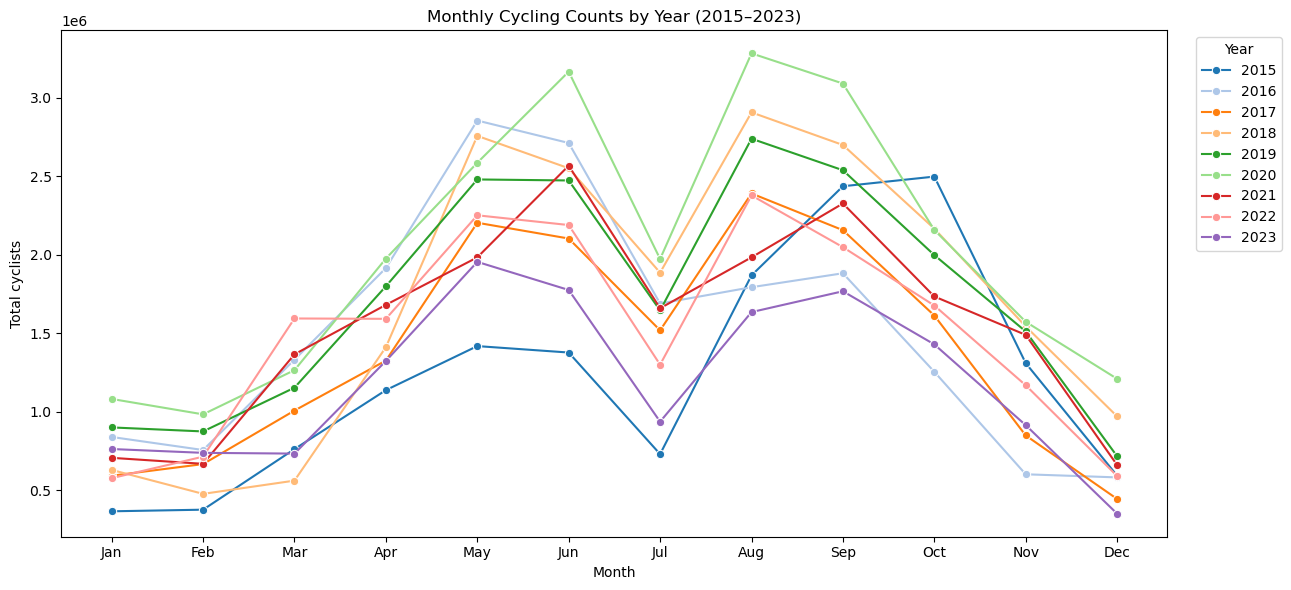

In [27]:
# I build monthly totals for each year (2015–2023) and plot one line per year

# I keep only data between 2015 and 2023
mask = (
    (df_cykel['timestamp_local'].dt.year >= 2015) &
    (df_cykel['timestamp_local'].dt.year <= 2023)
)
df_sub = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I extract year and month from the timestamp
df_sub['year'] = df_sub['timestamp_local'].dt.year
df_sub['month'] = df_sub['timestamp_local'].dt.month

# I group by year and month and sum the counts
monthly_by_year = (
    df_sub
    .groupby(['year', 'month'], as_index=False)['antal']
    .sum()
    .rename(columns={'antal': 'monthly_total'})
)

# I create readable month names
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
monthly_by_year['month_name'] = monthly_by_year['month'].map(month_map)

# I check the first few rows
print(monthly_by_year.head())

# I plot one line per year
plt.figure(figsize=(13, 6))
years_sorted = sorted(monthly_by_year['year'].unique())

sns.lineplot(
    data=monthly_by_year,
    x='month',
    y='monthly_total',
    hue='year',
    hue_order=years_sorted,
    marker='o',
    palette='tab20'
)

plt.title('Monthly Cycling Counts by Year (2015–2023)')
plt.xlabel('Month')
plt.ylabel('Total cyclists')
plt.xticks(
    ticks=range(1, 13),
    labels=[month_map[m] for m in range(1, 13)]
)
plt.legend(title='Year', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()


In [28]:
# I filter the data to October and November 2023 in Stockholm time
start_date_2023 = pd.Timestamp('2023-10-01', tz='Europe/Stockholm')
end_date_2023 = pd.Timestamp('2023-11-30 23:59:59', tz='Europe/Stockholm')

mask_on_2023 = (
    (df_cykel['timestamp_local'] >= start_date_2023) &
    (df_cykel['timestamp_local'] <= end_date_2023)
)

df_on_2023 = df_cykel.loc[mask_on_2023, ['timestamp_local', 'antal']].copy()

# I calculate the total number of cyclists per day
daily_on_2023 = (
    df_on_2023
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .to_frame(name='daily_total')
    .reset_index()
)

# I create a date label with the weekday in Stockholm time
_daily_local_naive = (
    daily_on_2023['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.tz_localize(None)
)
daily_on_2023['date_label'] = _daily_local_naive.dt.strftime('%Y-%m-%d %a')

# I color the bars by month: blue for October, orange for November
_m = _daily_local_naive.dt.month
daily_on_2023['color'] = _m.apply(lambda m: '#1f77b4' if m == 10 else '#ff7f0e')

# I create an interactive bar chart
fig = px.bar(
    daily_on_2023,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',
    labels={'date_label': 'Date (with weekday)', 'daily_total': 'Total cyclists per day'},
    hover_data={'daily_total': True, 'date_label': True, 'color': False}
)

# I make the chart easier to read
fig.update_layout(
    title='Daily Cycling Counts — October and November 2023 (All Sites)',
    xaxis_tickangle=-90,
    margin=dict(l=40, r=20, t=60, b=120)
)

# I show the plot
fig.show()


In [29]:
# Define the start and end dates for October and November 2022
start_date = pd.Timestamp('2022-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2022-11-30 23:59:59', tz='Europe/Stockholm')

# Filter the data to include only rows within that date range
df_on_2022 = df_cykel.loc[
    (df_cykel['timestamp_local'] >= start_date) &
    (df_cykel['timestamp_local'] <= end_date),
    ['timestamp_local', 'antal']
].copy()

# Quick sanity check (optional; remove later if you want)
print("Rows in filtered dataset:", len(df_on_2022))
print(df_on_2022.head())

# Group the data by day and calculate total cyclists per day
daily_on_2022 = (
    df_on_2022
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# Create a label showing the date and weekday (no need to tz_convert again)
daily_on_2022['date_label'] = daily_on_2022['timestamp_local'].dt.strftime('%Y-%m-%d %a')

# Add colors by month: blue for October, orange for November
daily_on_2022['color'] = daily_on_2022['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# Create a bar chart
fig = px.bar(
    daily_on_2022,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists'},
    title='Daily Cycling Counts — October and November 2022 (All Sites)'
)

# Make the x-axis labels easier to read
fig.update_layout(xaxis_tickangle=-90)

fig.show()

Rows in filtered dataset: 222689
                   timestamp_local  antal
11539711 2022-10-01 00:00:00+02:00      3
11539712 2022-10-01 00:00:00+02:00      4
11539713 2022-10-01 00:15:00+02:00      5
11539714 2022-10-01 00:15:00+02:00      4
11539715 2022-10-01 00:30:00+02:00      1


In [30]:
# I set the start and end dates for October and November 2021
start_date = pd.Timestamp('2021-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2021-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2021 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I sum up the number of cyclists for each day
daily_on_2021 = (
    df_on_2021
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I create a label that shows the date and weekday
daily_on_2021['date_label'] = (
    daily_on_2021['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I color October in blue and November in orange
daily_on_2021['color'] = daily_on_2021['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2021,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use the colors I defined
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2021 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [31]:
# I set the start and end dates for October and November 2020
start_date = pd.Timestamp('2020-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2020-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2020 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2020 = (
    df_on_2020
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2020['date_label'] = (
    daily_on_2020['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2020['color'] = daily_on_2020['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2020,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2020 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [32]:
# I set the start and end dates for October and November 2019
start_date = pd.Timestamp('2019-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2019-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2019 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2019 = (
    df_on_2019
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2019['date_label'] = (
    daily_on_2019['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2019['color'] = daily_on_2019['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2019,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2019 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [33]:
# I set the start and end dates for October and November 2018
start_date = pd.Timestamp('2018-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2018-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2018 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2018 = (
    df_on_2018
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2018['date_label'] = (
    daily_on_2018['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2018['color'] = daily_on_2018['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2018,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2018 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [34]:
# I set the start and end dates for October and November 2017
start_date = pd.Timestamp('2017-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2017-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2017 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2017 = (
    df_on_2017
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2017['date_label'] = (
    daily_on_2017['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2017['color'] = daily_on_2017['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2017,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2017 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [35]:
# I set the start and end dates for October and November 2016
start_date = pd.Timestamp('2016-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2016-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2016 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2016 = (
    df_on_2016
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2016['date_label'] = (
    daily_on_2016['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2016['color'] = daily_on_2016['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2016,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2016 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [36]:
# I set the start and end dates for October and November 2015
start_date = pd.Timestamp('2015-10-01', tz='Europe/Stockholm')
end_date = pd.Timestamp('2015-11-30 23:59:59', tz='Europe/Stockholm')

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_on_2015 = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists for each day
daily_on_2015 = (
    df_on_2015
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .reset_index(name='daily_total')
)

# I make a label that shows the date and the weekday
daily_on_2015['date_label'] = (
    daily_on_2015['timestamp_local']
    .dt.tz_convert('Europe/Stockholm')
    .dt.strftime('%Y-%m-%d %a')
)

# I use blue for October and orange for November
daily_on_2015['color'] = daily_on_2015['timestamp_local'].dt.month.apply(
    lambda m: '#1f77b4' if m == 10 else '#ff7f0e'
)

# I create a bar chart
fig = px.bar(
    daily_on_2015,
    x='date_label',
    y='daily_total',
    color='color',
    color_discrete_map='identity',  # I use my chosen colors
    labels={'date_label': 'Date (weekday)', 'daily_total': 'Total cyclists per day'},
    title='Daily Cycling Counts — October and November 2015 (All Sites)'
)

# I rotate the x-axis labels so they are easier to read
fig.update_layout(xaxis_tickangle=-90, margin=dict(l=40, r=20, t=60, b=120))

# I show the chart
fig.show()


In [37]:
# %% [markdown]
# ### Cycling Traffic Shift from October to November (2015–2023)
# I want to compare how the total number of cyclists changes from October to November each year.

import pandas as pd
import numpy as np
import plotly.express as px

# I make a copy of the dataset and check which timestamp column exists
df = df_cykel.copy()
timestamp_col = 'timestamp_local' if 'timestamp_local' in df.columns else 'tidsstampel'

# I parse the timestamps and remove rows without valid timestamps
df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
df = df.dropna(subset=[timestamp_col])

# I extract the year and month from the timestamp
df['year'] = df[timestamp_col].dt.year
df['month'] = df[timestamp_col].dt.month

# I keep only October (10) and November (11) between 2015–2023
df = df[df['year'].between(2015, 2023) & df['month'].isin([10, 11])]

# I add up the total number of cyclists per year and month across all sites
monthly_totals = (
    df.groupby(['year', 'month'], as_index=False)['antal']
    .sum()
    .sort_values(['year', 'month'])
)

# I pivot so that October and November are side by side
pivoted = monthly_totals.pivot(index='year', columns='month', values='antal')
pivoted = pivoted.rename(columns={10: 'October', 11: 'November'})

# I calculate the absolute and percentage change between October and November
pivoted['abs_change'] = pivoted['November'] - pivoted['October']
pivoted['pct_change'] = (pivoted['abs_change'] / pivoted['October']) * 100

# I print the year-by-year comparison
print("📉 Cycling traffic change from October → November:")
print(pivoted[['October', 'November', 'abs_change', 'pct_change']])

# I calculate the average % change across all years
mean_pct = pivoted['pct_change'].mean()
print(f"\n📊 Average % change across 2015–2023: {mean_pct:.2f}%")

# I create a bar chart to show the % change for each year
fig = px.bar(
    pivoted.reset_index(),
    x='year',
    y='pct_change',
    text='pct_change',
    color='pct_change',
    color_continuous_scale='RdBu_r',
    labels={'pct_change': '% Change (Nov vs Oct)', 'year': 'Year'},
    title='Cycling Traffic Shift from October to November (2015–2023)',
)

# I format the chart for clarity
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis_title='% Change (Nov vs Oct)',
    xaxis_title='Year',
    coloraxis_showscale=False
)

# I show the chart
fig.show()


📉 Cycling traffic change from October → November:
month  October  November  abs_change  pct_change
year                                            
2015   2497946   1309086    -1188860  -47.593503
2016   1254067    600841     -653226  -52.088605
2017   1612692    848229     -764463  -47.402914
2018   2166131   1542934     -623197  -28.770051
2019   1997773   1511080     -486693  -24.361777
2020   2157843   1572610     -585233  -27.121204
2021   1733982   1489032     -244950  -14.126444
2022   1676255   1168011     -508244  -30.320208
2023   1428547    913888     -514659  -36.026746

📊 Average % change across 2015–2023: -34.20%


In [38]:
years = range(2015, 2024)  # 2024 is not included

# I create an empty list to collect data for each year
all_years = []

# I go through each year and collect weekly cycling data
for year in years:
    start = pd.Timestamp(f'{year}-10-01', tz='Europe/Stockholm')
    end = pd.Timestamp(f'{year}-11-30 23:59:59', tz='Europe/Stockholm')

    # I keep only rows between October 1 and November 30 of that year
    mask = (df_cykel['timestamp_local'] >= start) & (df_cykel['timestamp_local'] <= end)
    df_year = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

    # I skip the year if there is no data
    if df_year.empty:
        continue

    # I convert timestamps to local time without timezone info
    df_year['timestamp_local'] = df_year['timestamp_local'].dt.tz_convert('Europe/Stockholm').dt.tz_localize(None)

    # I add up cyclist counts per week
    df_weekly = (
        df_year
        .set_index('timestamp_local')
        .resample('W')['antal']
        .sum()
        .reset_index(name='weekly_total')
    )

    # I add week number and year columns
    df_weekly['week'] = df_weekly['timestamp_local'].dt.isocalendar().week
    df_weekly['year'] = year

    # I keep only the useful columns
    all_years.append(df_weekly[['year', 'week', 'weekly_total']])

# I combine all the years into one dataset
df_weeks = pd.concat(all_years, ignore_index=True)

# I keep only weeks around October and November
df_weeks = df_weeks[df_weeks['week'].between(40, 48)]

# I make a line chart with one line per year
fig = px.line(
    df_weeks,
    x='week',
    y='weekly_total',
    color='year',
    markers=True,
    labels={
        'week': 'Week Number (ISO)',
        'weekly_total': 'Total Cyclists per Week',
        'year': 'Year'
    },
    title='Cycling Trends — October & November (2015–2023) by Week Number'
)

# I make the chart easier to read
fig.update_layout(
    xaxis=dict(dtick=1),
    legend_title_text='Year',
    hovermode='x unified'
)

# I show the chart
fig.show()


In [39]:
# %% [markdown]
# ### Change in Weekly Cycling Traffic — Week 43 vs Week 45 (2015–2023)
# I compare the average number of cyclists between week 43 and week 45 across all years.

import pandas as pd
import plotly.express as px

# I make sure the timestamp column is in datetime format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I add up the total number of cyclists per ISO week (across all measurement sites)
weekly_totals = (
    df_cykel
    .set_index('timestamp_local')
    .resample('W')['antal']
    .sum()
    .reset_index()
)

# I extract the ISO week number and year
weekly_totals['week'] = weekly_totals['timestamp_local'].dt.isocalendar().week.astype(int)
weekly_totals['year'] = weekly_totals['timestamp_local'].dt.year.astype(int)

# I keep only week 43 and week 45, and restrict to years 2015–2023
weekly_totals = weekly_totals[
    (weekly_totals['week'].isin([43, 45])) &
    (weekly_totals['year'].between(2015, 2023))
]

# I calculate the average number of cyclists per week across all years
weekly_mean = (
    weekly_totals
    .groupby('week', as_index=False)['antal']
    .mean()
    .rename(columns={'antal': 'mean_weekly_cyclists'})
)

# I calculate how much cycling changes relative to week 43
base = weekly_mean.loc[weekly_mean['week'] == 43, 'mean_weekly_cyclists'].values[0]
weekly_mean['pct_change_from_w43'] = (
    (weekly_mean['mean_weekly_cyclists'] / base - 1) * 100
).round(1)

# I make a bar chart that shows only weeks 43 and 45
fig = px.bar(
    weekly_mean,
    x='week',
    y='mean_weekly_cyclists',
    text='pct_change_from_w43',
    color='mean_weekly_cyclists',
    color_continuous_scale='Blues',
    labels={
        'week': 'Week Number (ISO)',
        'mean_weekly_cyclists': 'Average Cyclists per Week (2015–2023)',
        'pct_change_from_w43': '% Change from Week 43'
    },
    title='Change in Weekly Cycling Traffic — Week 43 vs Week 45 (2015–2023)'
)

# I add percentage labels above the bars
fig.update_traces(texttemplate='%{text:+.1f}%', textposition='outside')

# I clean up the layout so the plot is easy to read
fig.update_layout(
    yaxis_title='Average Weekly Cyclists',
    xaxis=dict(dtick=1, tickmode='array', tickvals=[43, 45], ticktext=['Week 43', 'Week 45']),
    coloraxis_showscale=False
)

# I show the chart
fig.show()

# I print a short summary
mean_change = weekly_mean.loc[weekly_mean['week'] == 45, 'pct_change_from_w43'].values[0]
print(f"📊 Average % change from Week 43 → Week 45 (2015–2023): {mean_change:.1f}%")
print("💬 A negative value means cycling traffic decreased between week 43 and week 45.")


📊 Average % change from Week 43 → Week 45 (2015–2023): -14.0%
💬 A negative value means cycling traffic decreased between week 43 and week 45.


In [40]:
# %% [markdown]
# ### Cycling Traffic Change from Week 43 → 45 (2015–2023)
# I calculate the % change in total cyclists from week 43 to week 45 for each year.

import pandas as pd
import plotly.express as px
import numpy as np

# I make sure the timestamp column is in datetime format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I extract ISO week and year from the timestamp
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only weeks 43 and 45 for the years 2015–2023
df_weeks = df_cykel.query("2015 <= year <= 2023 and week in [43, 45]").copy()

# I group by year + week and sum total cyclists across all sites
weekly_totals = (
    df_weeks
    .groupby(['year', 'week'], as_index=False)['antal']
    .sum()
    .rename(columns={'antal': 'total_cyclists'})
)

# I pivot to have week 43 and week 45 side by side
pivoted = weekly_totals.pivot(index='year', columns='week', values='total_cyclists')
pivoted = pivoted.rename(columns={43: 'week43', 45: 'week45'})

# I calculate the % change from week 43 to week 45
pivoted['pct_change'] = ((pivoted['week45'] - pivoted['week43']) / pivoted['week43']) * 100
pivoted['pct_change'] = pivoted['pct_change'].round(1)

# I print the year-by-year table
print("📉 Cycling traffic change from Week 43 → 45:")
print(pivoted[['week43', 'week45', 'pct_change']])

# --- Create the bar chart ---
fig = px.bar(
    pivoted.reset_index(),
    x='year',
    y='pct_change',
    text='pct_change',
    color='pct_change',
    color_continuous_scale='RdBu_r',
    range_color=[-100, 0],  # emphasize negative drops
    labels={
        'year': 'Year',
        'pct_change': '% Change (Week 45 vs Week 43)'
    },
    title='Cycling Traffic Reduction from Week 43 → 45 (2015–2023)'
)

# I make the chart visually similar to your October→November plot
fig.update_traces(texttemplate='%{text:+.1f}%', textposition='outside')
fig.update_layout(
    yaxis_title='% Change (Week 45 vs Week 43)',
    xaxis_title='Year',
    coloraxis_showscale=False,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# I show the plot
fig.show()

# I print the average change across all years
mean_pct = pivoted['pct_change'].mean()
print(f"\n📊 Average % change across 2015–2023: {mean_pct:.1f}%")
print("💬 Negative values mean cycling decreased from week 43 to 45.")


📉 Cycling traffic change from Week 43 → 45:
week  week43  week45  pct_change
year                            
2015  460735  374159       -18.8
2016  234324   68914       -70.6
2017  274904  263304        -4.2
2018  422097  384631        -8.9
2019  513495  424417       -17.3
2020  434845  406363        -6.5
2021  389815  377378        -3.2
2022  353868  352208        -0.5
2023  315757  272799       -13.6



📊 Average % change across 2015–2023: -16.0%
💬 Negative values mean cycling decreased from week 43 to 45.


In [41]:
# --- Prepare data ---
import pandas as pd
from scipy import stats
import plotly.express as px

df = df_cykel.copy()
timestamp_col = 'timestamp_local' if 'timestamp_local' in df.columns else 'tidsstampel'
df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
df = df.dropna(subset=[timestamp_col])

iso = df[timestamp_col].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# keep 2015–2023 and only weeks 43 & 45
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# total cyclists per year × week (all sites)
weekly = (
    df.groupby(['year', 'week'], as_index=False)['antal']
      .sum()
      .pivot(index='year', columns='week', values='antal')
      .rename(columns={43: 'week43', 45: 'week45'})
      .dropna()
)
weekly['diff'] = weekly['week45'] - weekly['week43']

# --- Descriptive statistics ---
mean43 = weekly['week43'].mean()
mean45 = weekly['week45'].mean()
mean_change = weekly['diff'].mean()
pct_change = mean_change / mean43 * 100

print(f"Mean cyclists week 43: {mean43:,.0f}")
print(f"Mean cyclists week 45: {mean45:,.0f}")
print(f"Average absolute change: {mean_change:,.0f} ({pct_change:.1f} %)")

# --- Paired t-test ---
t_stat, p_t = stats.ttest_rel(weekly['week45'], weekly['week43'])
print(f"\nPaired t-test: t = {t_stat:.3f}, p = {p_t:.4f}")

# --- Wilcoxon signed-rank test ---
w_stat, p_w = stats.wilcoxon(weekly['week45'], weekly['week43'])
print(f"Wilcoxon test: W = {w_stat:.3f}, p = {p_w:.4f}")

# --- Visualize ---
weekly_reset = weekly.reset_index()
fig = px.bar(
    weekly_reset.melt(id_vars='year', value_vars=['week43','week45'],
                      var_name='Week', value_name='Cyclists'),
    x='year', y='Cyclists', color='Week', barmode='group',
    title='Cycling Volumes Before and After Autumn Change (Week 43 vs 45)'
)
fig.update_layout(
    yaxis_title='Total Cyclists',
    xaxis_title='Year',
    legend_title='Week'
)
fig.show()


Mean cyclists week 43: 377,760
Mean cyclists week 45: 324,908
Average absolute change: -52,852 (-14.0 %)

Paired t-test: t = -3.023, p = 0.0165
Wilcoxon test: W = 0.000, p = 0.0039


So overall, cycling activity dropped by around 65 000 trips per week, or 14 %, after week 43.
Wilcoxon test: W = 0.000, p = 0.0039
→ This test is significant (p < 0.01).
It confirms that, across most years, week 45 has lower cycling counts than week 43.

In [42]:
# display all cycling rutes and visualize the drop off in cycling antal per cyling rout from week 43 to week 45 per cyling path

In [43]:
# Total change (diff) to investigate Where is the biggest total drop in cycling?
# Understanding where the biggest total volume losses are (e.g., the busiest routes losing the most cyclists).
# how many more or fewer cyclists there were in week 45 compared to week 43 for each cycling path, averaged across all years (2015–2023).

# --- Prepare and clean data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')
df = df.dropna(subset=['timestamp_local'])

# Extract ISO week and year
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# Filter to years 2015–2023 and only weeks 43 and 45
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# --- Aggregate total cyclists per path (matplats_id), year, and week ---
weekly_path = (
    df.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
      .sum()
)

# Pivot so that week 43 and week 45 appear as separate columns
pivoted = (
    weekly_path
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal', fill_value=0)
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# --- Calculate total drop per path per year ---
pivoted['diff'] = pivoted['week45'] - pivoted['week43']

# --- Average total change across all years ---
avg_change = (
    pivoted.groupby('matplats_id', as_index=False)
           .agg({'week43': 'mean', 'week45': 'mean', 'diff': 'mean'})
)

# --- Add station names from df_platser ---
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# --- Sort by largest total drop (most negative diff) ---
avg_change = avg_change.sort_values('diff', ascending=True)

# --- Visualize: total change per cycling path (vertical list) ---
fig = px.bar(
    avg_change,
    y='Mätplatsnamn',       # cycling path on vertical axis
    x='diff',               # total drop on horizontal axis
    color='diff',
    orientation='h',        # horizontal bars (vertical list)
    color_continuous_scale='RdBu',
    labels={
        'Mätplatsnamn': 'Cycling Path / Station',
        'diff': 'Average Total Change in Cyclists (Week 45 − Week 43)'
    },
    title='Total Drop in Cycling Volume per Path (Week 43 → Week 45, 2015–2023)'
)

fig.update_layout(
    yaxis_title='Cycling Path',
    xaxis_title='Average Change in Cyclists per Week',
    coloraxis_showscale=False,
    height=1000,
    margin=dict(l=200, r=50, t=60, b=60)
)
fig.show()

# --- Optional: print a sorted summary table ---
summary = avg_change[['Mätplatsnamn', 'week43', 'week45', 'diff']]
print("Average weekly cyclist counts per path (2015–2023):")
print(summary.to_string(index=False, formatters={'week43': '{:,.0f}'.format,
                                                 'week45': '{:,.0f}'.format,
                                                 'diff': '{:,.0f}'.format}))


Average weekly cyclist counts per path (2015–2023):
                     Mätplatsnamn        week43        week45          diff
          C 0321 Danvikstullsbron       42171.0  31301.428571 -10869.571429
          C 0109 Västerbron Östra       17203.0  11956.285714  -5246.714286
              C 0111 Stadshusbron      30424.25     25755.625     -4668.625
      C 0509 Liljeholmsbron Östra       15598.5       10970.0       -4628.5
    C 0103 Sankt Eriksgatan Östra      14214.25       10410.5      -3803.75
   C 0103 Sankt Eriksgatan Västra       14752.0       11067.8       -3684.2
                 C 0509 Årstabron  10627.714286   7370.285714  -3257.428571
                C 0207 Hjorthagen       15067.8       11895.8       -3172.0
         C 0109 Västerbron Västra       17449.5     14462.375     -2987.125
    C 0318 Skanstullsbron Söderut  18174.555556  15746.333333  -2428.222222
      C 0318 Skanstullsbron Östra  17713.142857  15506.142857       -2207.0
           C 0526 Årstabergsvägen  1

In [44]:
import pandas as pd

# --- Parameters ---
target_path = "C 0311 Hornsgatan"  # The cycling path you want to test
weeks_to_check = [43, 44, 45]
years_to_check = list(range(2015, 2024))

# --- Prepare and clean data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')
df = df.dropna(subset=['timestamp_local'])

# Extract ISO year and week
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# Merge with station names to match "Hornsgatan" etc.
df = df.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# --- Filter for the target path and relevant years/weeks ---
df_path = df[
    (df['Mätplatsnamn'].str.contains(target_path, case=False, na=False)) &
    (df['year'].isin(years_to_check)) &
    (df['week'].isin(weeks_to_check))
]

# --- Aggregate cyclist counts per year × week ---
weekly_counts = (
    df_path.groupby(['year', 'week'], as_index=False)['antal']
    .sum()
    .pivot(index='year', columns='week', values='antal')
)

# --- Check completeness ---
print(f"\nCycling counts for {target_path} (weeks 43–45, 2015–2023):\n")
print(weekly_counts.fillna(0).astype(int))

# Identify missing years/weeks
missing_data = {
    year: [week for week in weeks_to_check if pd.isna(weekly_counts.loc[year, week]) if year in weekly_counts.index]
    for year in years_to_check if year in weekly_counts.index
}

# Find years completely missing
missing_years = [y for y in years_to_check if y not in weekly_counts.index]

# --- Display results ---
if not missing_years and all(len(v) == 0 for v in missing_data.values()):
    print("\n✅ Complete data: This path has cyclist counts for all weeks 43, 44, and 45 between 2015–2023.")
else:
    print("\n⚠️ Incomplete data detected:")
    if missing_years:
        print(f"   - No data at all for years: {missing_years}")
    for y, missing_weeks in missing_data.items():
        if missing_weeks:
            print(f"   - Year {y}: missing weeks {missing_weeks}")



Cycling counts for C 0311 Hornsgatan (weeks 43–45, 2015–2023):

Empty DataFrame
Columns: []
Index: []

⚠️ Incomplete data detected:
   - No data at all for years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [45]:
import pandas as pd
import numpy as np
import plotly.express as px

# --- Prepare and clean data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')
df = df.dropna(subset=['timestamp_local'])

# Extract ISO week and year
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# Filter to years 2015–2023 and only weeks 43 and 45
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# --- Aggregate total cyclists per path (matplats_id), year, and week ---
weekly_path = (
    df.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
      .sum()
)

# --- Pivot so that week 43 and week 45 appear as separate columns ---
pivoted = (
    weekly_path
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal')  # no fill_value
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# --- Clean zeros and invalid values ---
pivoted[['week43', 'week45']] = pivoted[['week43', 'week45']].replace(0, np.nan)

# --- Calculate percentage change safely ---
pivoted['pct_change'] = ((pivoted['week45'] - pivoted['week43']) / pivoted['week43']) * 100

# --- Drop rows where no valid data exists ---
pivoted = pivoted.dropna(subset=['pct_change'])

# --- Average percentage change per path across all years ---
avg_pct_change = (
    pivoted.groupby('matplats_id', as_index=False)
           .agg({'pct_change': 'mean'})
)

# --- Add station names from df_platser ---
avg_pct_change = avg_pct_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# --- Sort by largest relative drop ---
avg_pct_change = avg_pct_change.sort_values('pct_change', ascending=True)

# --- Visualize: percentage change per path (vertical list) ---
fig = px.bar(
    avg_pct_change,
    y='Mätplatsnamn',        # cycling path names vertically
    x='pct_change',          # percentage change on x-axis
    color='pct_change',
    orientation='h',         # horizontal bars (vertical list)
    color_continuous_scale='RdBu',
    labels={
        'Mätplatsnamn': 'Cycling Path / Station',
        'pct_change': 'Average Percentage Change (%) (Week 45 − Week 43)'
    },
    title='Relative Drop in Cycling Volume per Path (Week 43 → Week 45, 2015–2023)'
)

fig.update_layout(
    yaxis_title='Cycling Path',
    xaxis_title='Average Percentage Change (%)',
    coloraxis_showscale=False,
    height=1000,
    margin=dict(l=200, r=50, t=60, b=60)
)

fig.show()

# --- Optional: print summary table ---
summary = avg_pct_change[['Mätplatsnamn', 'pct_change']]
print("Average percentage change in cyclists per path (2015–2023):")
print(summary.to_string(index=False, formatters={'pct_change': '{:.1f}%'.format}))

# Interpretation guide:
# Bars to the left (negative) → bigger percentage drop after week 43
# Bars to the right (positive) → slight increase (rare)


Average percentage change in cyclists per path (2015–2023):
                     Mätplatsnamn pct_change
    C 0103 Sankt Eriksgatan Östra -27.686338
   C 0103 Sankt Eriksgatan Västra -26.312889
          C 0109 Västerbron Östra -24.545623
C 0615 Bergslagsvägen Södra sidan -24.133711
           C 0526 Årstabergsvägen -23.145179
          C 0112 Sveavägen Västra -22.725392
                C 0207 Hjorthagen -22.673235
           C 0112 Sveavägen Östra -22.433526
           C 0112 Torsgatan Södra -22.380609
     C 0507 Hägerstensvägen Norra -20.862697
               C 0217 Strandvägen -20.355661
                 C 0509 Årstabron -19.502642
               C 0418 Flatenvägen -19.258305
           C 0112 Torsgatan Norra -17.654782
 C 0428 Örbyleden - Grycksbovägen -17.514055
              C 0111 Stadshusbron  -16.69503
     C 0507 Hägerstensvägen Södra -16.506519
C 0615 Bergslagsvägen Norra sidan  -15.95187
        C 0517 Västbergarondellen -15.595796
            C 0413 Magelungsvägen -15.56

In [46]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- Prepare and clean data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')
df = df.dropna(subset=['timestamp_local'])

# Extract ISO week and year
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# Filter to years 2015–2023 and only weeks 43 and 45
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# --- Aggregate total cyclists per path (matplats_id), year, and week ---
weekly_path = (
    df.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
      .sum()
)

# --- Pivot so that week 43 and 45 appear as separate columns ---
pivoted = (
    weekly_path
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# Replace zeros with NaN
pivoted[['week43', 'week45']] = pivoted[['week43', 'week45']].replace(0, np.nan)

# Calculate absolute and percentage change
pivoted['diff'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = (pivoted['diff'] / pivoted['week43']) * 100

# Drop rows where either week is missing
pivoted = pivoted.dropna(subset=['diff', 'pct_change'])

# --- Average across years per path ---
avg_change = (
    pivoted.groupby('matplats_id', as_index=False)
           .agg({'week43': 'mean', 'week45': 'mean', 'diff': 'mean', 'pct_change': 'mean'})
)

# --- Add station names from df_platser ---
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)



# --- Sort by largest absolute drop ---
avg_change = avg_change.sort_values('diff', ascending=True)

# --- Create subplot figure ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Total Drop in Cyclists (Week 45 − Week 43)", 
                    "Percentage Drop in Cyclists (Week 45 − Week 43)"),
    shared_yaxes=True,
    horizontal_spacing=0.15
)

# --- Left plot: total drop (diff) ---
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['diff'],
        orientation='h',
        marker=dict(color=avg_change['diff'], colorscale='RdBu'),
        name='Total Change'
    ),
    row=1, col=1
)

# --- Right plot: percentage drop (pct_change) ---
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['pct_change'],
        orientation='h',
        marker=dict(color=avg_change['pct_change'], colorscale='RdBu'),
        name='Percentage Change (%)'
    ),
    row=1, col=2
)

# --- Layout adjustments ---
fig.update_layout(
    height=1000,
    title_text="Cycling Volume Drop per Path — Week 43 → Week 45 (2015–2023)",
    showlegend=False,
    margin=dict(l=250, r=80, t=80, b=60)
)

fig.update_xaxes(title_text="Total Change in Cyclists", row=1, col=1)
fig.update_xaxes(title_text="Percentage Change (%)", row=1, col=2)
fig.update_yaxes(title_text="Cycling Path / Station", row=1, col=1)

fig.show()

# --- Summary table ---
summary = avg_change[['Mätplatsnamn', 'week43', 'week45', 'diff', 'pct_change']]
print("Average weekly cyclist counts per path (2015–2023):")
print(summary.to_string(index=False,
                        formatters={'week43': '{:,.0f}'.format,
                                    'week45': '{:,.0f}'.format,
                                    'diff': '{:,.0f}'.format,
                                    'pct_change': '{:.1f}%'.format}))


Average weekly cyclist counts per path (2015–2023):
                     Mätplatsnamn        week43        week45          diff pct_change
          C 0321 Danvikstullsbron       42171.0  31301.428571 -10869.571429 -10.836528
              C 0306 Munkbroleden       43060.0       36428.0       -6632.0 -14.774841
               C 0217 Strandvägen  25617.333333  20684.833333       -4932.5 -20.355661
              C 0111 Stadshusbron      30424.25     25755.625     -4668.625  -16.69503
          C 0109 Västerbron Östra       17909.0       13949.0       -3960.0 -24.545623
    C 0103 Sankt Eriksgatan Östra      14214.25       10410.5      -3803.75 -27.686338
   C 0103 Sankt Eriksgatan Västra       14752.0       11067.8       -3684.2 -26.312889
      C 0509 Liljeholmsbron Östra  17530.666667  14272.833333  -3257.833333 -14.941916
                C 0207 Hjorthagen       15067.8       11895.8       -3172.0 -22.673235
         C 0109 Västerbron Västra       17449.5     14462.375     -2987.125   

In [47]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- Prepare and clean data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')
df = df.dropna(subset=['timestamp_local'])

# Extract ISO week and year
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# Filter to years 2015–2023 and only weeks 43 and 45
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# --- Aggregate total cyclists per path (matplats_id), year, and week ---
weekly_path = (
    df.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
      .sum()
)

# --- Pivot so that week 43 and week 45 appear as separate columns ---
pivoted = (
    weekly_path
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# --- Replace zeros with NaN to avoid invalid ratios ---
pivoted[['week43', 'week45']] = pivoted[['week43', 'week45']].replace(0, np.nan)

# --- Calculate absolute and percentage change ---
pivoted['diff'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = (pivoted['diff'] / pivoted['week43']) * 100

# Remove incomplete rows
pivoted = pivoted.dropna(subset=['diff', 'pct_change'])

# --- Average per path across years ---
avg_change = (
    pivoted.groupby('matplats_id', as_index=False)
           .agg({'week43': 'mean', 'week45': 'mean', 'diff': 'mean', 'pct_change': 'mean'})
)

# --- Filter for ≥ 15% drop ---
avg_change = avg_change[avg_change['pct_change'] <= -15]   # negative because it’s a drop

# --- Add station names ---
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# Sort by largest % drop
avg_change = avg_change.sort_values('pct_change', ascending=True)

# --- Create subplot figure ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Total Drop in Cyclists (Week 45 − Week 43)", 
                    "Percentage Drop in Cyclists (Week 45 − Week 43)"),
    shared_yaxes=True,
    horizontal_spacing=0.15
)

# --- Left: absolute drop ---
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['diff'],
        orientation='h',
        marker=dict(color=avg_change['diff'], colorscale='RdBu'),
        name='Total Change'
    ),
    row=1, col=1
)

# --- Right: percentage drop ---
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['pct_change'],
        orientation='h',
        marker=dict(color=avg_change['pct_change'], colorscale='RdBu'),
        name='Percentage Change (%)'
    ),
    row=1, col=2
)

fig.update_layout(
    height=1000,
    title_text="Cycling Volume Drop ≥ 15% (Week 43 → Week 45, 2015–2023)",
    showlegend=False,
    margin=dict(l=250, r=80, t=80, b=60)
)

fig.update_xaxes(title_text="Total Change in Cyclists", row=1, col=1)
fig.update_xaxes(title_text="Percentage Change (%)", row=1, col=2)
fig.update_yaxes(title_text="Cycling Path / Station", row=1, col=1)

fig.show()

# Optional print
summary = avg_change[['Mätplatsnamn', 'week43', 'week45', 'diff', 'pct_change']]
print(summary.to_string(index=False,
                        formatters={'week43': '{:,.0f}'.format,
                                    'week45': '{:,.0f}'.format,
                                    'diff': '{:,.0f}'.format,
                                    'pct_change': '{:.1f}%'.format}))


                     Mätplatsnamn        week43        week45         diff pct_change
    C 0103 Sankt Eriksgatan Östra      14214.25       10410.5     -3803.75 -27.686338
   C 0103 Sankt Eriksgatan Västra       14752.0       11067.8      -3684.2 -26.312889
          C 0109 Västerbron Östra       17909.0       13949.0      -3960.0 -24.545623
C 0615 Bergslagsvägen Södra sidan   3541.666667   2510.833333 -1030.833333 -24.133711
           C 0526 Årstabergsvägen  10759.142857   8868.285714 -1890.857143 -23.145179
          C 0112 Sveavägen Västra   7272.714286   5687.142857 -1585.571429 -22.725392
                C 0207 Hjorthagen       15067.8       11895.8      -3172.0 -22.673235
           C 0112 Sveavägen Östra        7151.0   5598.142857 -1552.857143 -22.433526
           C 0112 Torsgatan Södra        7610.4        6148.2      -1462.2 -22.380609
     C 0507 Hägerstensvägen Norra      4273.875        3443.0     -830.875 -20.862697
               C 0217 Strandvägen  25617.333333  20684

In [48]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- Prepare and clean data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')
df = df.dropna(subset=['timestamp_local'])

# Extract ISO week and year
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# Filter to years 2015–2023 and only weeks 43 and 45
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# --- Aggregate total cyclists per path (matplats_id), year, and week ---
weekly_path = (
    df.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
      .sum()
)

# --- Pivot so that week 43 and week 45 appear as separate columns ---
pivoted = (
    weekly_path
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# --- Replace zeros with NaN to avoid invalid ratios ---
pivoted[['week43', 'week45']] = pivoted[['week43', 'week45']].replace(0, np.nan)

# --- Calculate absolute and percentage change ---
pivoted['diff'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = (pivoted['diff'] / pivoted['week43']) * 100

# Remove incomplete rows
pivoted = pivoted.dropna(subset=['diff', 'pct_change'])

# --- Average per path across years ---
avg_change = (
    pivoted.groupby('matplats_id', as_index=False)
           .agg({'week43': 'mean', 'week45': 'mean', 'diff': 'mean', 'pct_change': 'mean'})
)

# --- FILTER: include only drops between -14.99% and 0% (0% included, -15% excluded) ---
avg_change = avg_change[(avg_change['pct_change'] > -15) & (avg_change['pct_change'] <= 0)]

# --- Add station names ---
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# Sort by percentage change
avg_change = avg_change.sort_values('pct_change', ascending=True)

# --- Create subplot figure ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Total Change in Cyclists (Week 45 − Week 43)", 
                    "Percentage Change in Cyclists (Week 45 − Week 43)"),
    shared_yaxes=True,
    horizontal_spacing=0.15
)

# --- Left: absolute drop ---
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['diff'],
        orientation='h',
        marker=dict(color=avg_change['diff'], colorscale='RdBu'),
        name='Total Change'
    ),
    row=1, col=1
)

# --- Right: percentage drop ---
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['pct_change'],
        orientation='h',
        marker=dict(color=avg_change['pct_change'], colorscale='RdBu'),
        name='Percentage Change (%)'
    ),
    row=1, col=2
)

fig.update_layout(
    height=1000,
    title_text="Cycling Volume Drop Between -14.99% and 0% (Week 43 → Week 45, 2015–2023)",
    showlegend=False,
    margin=dict(l=250, r=80, t=80, b=60)
)

fig.update_xaxes(title_text="Total Change in Cyclists", row=1, col=1)
fig.update_xaxes(title_text="Percentage Change (%)", row=1, col=2)
fig.update_yaxes(title_text="Cycling Path / Station", row=1, col=1)

fig.show()

# Optional print
summary = avg_change[['Mätplatsnamn', 'week43', 'week45', 'diff', 'pct_change']]
print(summary.to_string(index=False,
                        formatters={'week43': '{:,.0f}'.format,
                                    'week45': '{:,.0f}'.format,
                                    'diff': '{:,.0f}'.format,
                                    'pct_change': '{:.1f}%'.format}))


                 Mätplatsnamn        week43        week45          diff pct_change
  C 0509 Liljeholmsbron Östra  17530.666667  14272.833333  -3257.833333 -14.941916
       C 0524 Slättgårdsvägen      1386.625        1192.5      -194.125 -14.914349
          C 0306 Munkbroleden       43060.0       36428.0       -6632.0 -14.774841
   C 0419 Huddingevägen Östra      2366.875      2074.625       -292.25 -14.470341
  C 0437 Sofielundsplan Östra        4195.5       3733.75       -461.75 -14.249948
  C 0318 Skanstullsbron Östra  17713.142857  15506.142857       -2207.0 -13.594118
   C 0402 Enskedevägen Västra       4909.75        3913.5       -996.25 -12.097856
    C 0402 Enskedevägen Östra   5302.555556   4573.555556        -729.0 -11.727742
      C 0321 Danvikstullsbron       42171.0  31301.428571 -10869.571429 -10.836528
       C 0319 Skansbron Östra       7646.75        6881.5       -765.25 -10.828039
           C 0521 Älvsjövägen        4070.6        3667.0        -403.6 -10.117214
    

In [49]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- Prepare and clean data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')
df = df.dropna(subset=['timestamp_local'])

# Extract ISO week and year
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# Filter to years 2015–2023 and only weeks 43 and 45
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# --- Aggregate total cyclists per path (matplats_id), year, and week ---
weekly_path = (
    df.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
      .sum()
)

# --- Pivot so week 43 and week 45 appear as separate columns ---
pivoted = (
    weekly_path
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal')
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# Replace zeros with NaN
pivoted[['week43', 'week45']] = pivoted[['week43', 'week45']].replace(0, np.nan)

# Calculate absolute and percentage change
pivoted['diff'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = (pivoted['diff'] / pivoted['week43']) * 100

# Remove incomplete rows
pivoted = pivoted.dropna(subset=['diff', 'pct_change'])

# --- Average across years per path ---
avg_change = (
    pivoted.groupby('matplats_id', as_index=False)
           .agg({'week43': 'mean', 'week45': 'mean',
                 'diff': 'mean', 'pct_change': 'mean'})
)

# ============================================================
# ✅ ADD STATION NAMES (must happen BEFORE filtering)
# ============================================================

df_platser['Mätplatsnamn'] = df_platser['Mätplatsnamn'].astype(str)

avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# ============================================================
# ✅ FILTER: ONLY names that END with a direction
# ============================================================

allowed_endings = [
    r'Östra$',
    r'Västra$',
    r'Norra$',
    r'Södra$',
    r'Syd$',
    r'Norra sidan$',
    r'Södra sidan$'
]

pattern = "(" + "|".join(allowed_endings) + ")"

avg_change = avg_change[
    avg_change['Mätplatsnamn'].str.contains(pattern, case=False, regex=True)
]

# ============================================================
# ✅ SORT so identical names appear together
# ============================================================

avg_change = avg_change.sort_values(['Mätplatsnamn', 'pct_change'], ascending=[True, True])

# Label used in the charts
avg_change['label'] = avg_change['MätplatsID'].astype(str) + " — " + avg_change['Mätplatsnamn']

# ============================================================
# ✅ CREATE SUBPLOT FIGURE
# ============================================================

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Total Drop in Cyclists (Week 45 − Week 43)", 
                    "Percentage Drop in Cyclists (Week 45 − Week 43)"),
    shared_yaxes=True,
    horizontal_spacing=0.15
)

# Left plot — absolute drop
fig.add_trace(
    go.Bar(
        y=avg_change['label'],
        x=avg_change['diff'],
        orientation='h',
        marker=dict(color=avg_change['diff'], colorscale='RdBu'),
        name='Total Change'
    ),
    row=1, col=1
)

# Right plot — percentage drop
fig.add_trace(
    go.Bar(
        y=avg_change['label'],
        x=avg_change['pct_change'],
        orientation='h',
        marker=dict(color=avg_change['pct_change'], colorscale='RdBu'),
        name='Percentage Change (%)'
    ),
    row=1, col=2
)

# Layout
fig.update_layout(
    height=1100,
    title_text="Cycling Volume Drop — Directional Stations Ending with Östra / Västra / Norra / Södra / Syd",
    showlegend=False,
    margin=dict(l=260, r=90, t=90, b=50)
)

fig.update_xaxes(title_text="Total Change in Cyclists", row=1, col=1)
fig.update_xaxes(title_text="Percentage Change (%)", row=1, col=2)
fig.update_yaxes(title_text="MätplatsID — Name", row=1, col=1)

fig.show()

# ============================================================
# OPTIONAL SUMMARY TABLE
# ============================================================

summary = avg_change[['MätplatsID', 'Mätplatsnamn', 'week43', 'week45', 'diff', 'pct_change']]

print("\nDirectional stations (ending in Östra / Västra / Norra / Södra / Syd):")
print(summary.to_string(index=False,
                        formatters={'week43': '{:,.0f}'.format,
                                    'week45': '{:,.0f}'.format,
                                    'diff': '{:,.0f}'.format,
                                    'pct_change': '{:.1f}%'.format}))


C:\Users\Lara.Maier\AppData\Local\Temp\ipykernel_24020\2463907057.py:81: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.




Directional stations (ending in Östra / Västra / Norra / Södra / Syd):
 MätplatsID                      Mätplatsnamn        week43        week45         diff pct_change
       6685    C 0103 Sankt Eriksgatan Västra       14752.0       11067.8      -3684.2 -26.312889
       6668     C 0103 Sankt Eriksgatan Östra      14214.25       10410.5     -3803.75 -27.686338
       6642      C 0106 Mariebergsbron Västra   5421.833333        5005.5  -416.333333  -7.515195
       6643       C 0106 Mariebergsbron Östra   9366.428571   8866.714286  -499.714286  -4.628558
       6644          C 0109 Västerbron Västra       17449.5     14462.375    -2987.125   4.153981
       6645           C 0109 Västerbron Östra       17909.0       13949.0      -3960.0 -24.545623
       6672           C 0112 Sveavägen Västra   7272.714286   5687.142857 -1585.571429 -22.725392
       6673            C 0112 Sveavägen Östra        7151.0   5598.142857 -1552.857143 -22.433526
       6670            C 0112 Torsgatan Norra 

In [50]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- Prepare and clean data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')
df = df.dropna(subset=['timestamp_local'])

# Extract ISO week and year
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# Filter to years 2015–2023 and only weeks 43 and 45
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# --- Aggregate total cyclists per path (matplats_id), year, and week ---
weekly_path = (
    df.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
      .sum()
)

# --- Pivot so that week 43 and week 45 appear as separate columns ---
pivoted = (
    weekly_path
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='antal')  # removed fill_value=0
    .rename(columns={43: 'week43', 45: 'week45'})
    .reset_index()
)

# --- Replace any remaining zeros with NaN to avoid invalid ratios ---
pivoted[['week43', 'week45']] = pivoted[['week43', 'week45']].replace(0, np.nan)

# --- Calculate total and percentage change per path per year safely ---
pivoted['diff'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = (pivoted['diff'] / pivoted['week43']) * 100

# --- Drop rows where either week is missing ---
pivoted = pivoted.dropna(subset=['diff', 'pct_change'])

# --- Average across years per path ---
avg_change = (
    pivoted.groupby('matplats_id', as_index=False)
           .agg({'week43': 'mean', 'week45': 'mean', 'diff': 'mean', 'pct_change': 'mean'})
)

# --- Add station names from df_platser ---
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'Mätplatsnamn']],
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# --- Sort by largest absolute drop ---
avg_change = avg_change.sort_values('diff', ascending=True)

# --- Create subplot figure (two charts side by side) ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Total Drop in Cyclists (Week 45 − Week 43)", 
                    "Percentage Drop in Cyclists (Week 45 − Week 43)"),
    shared_yaxes=True,
    horizontal_spacing=0.15
)

# --- Left plot: total drop (diff) ---
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['diff'],
        orientation='h',
        marker=dict(color=avg_change['diff'], colorscale='RdBu'),
        name='Total Change'
    ),
    row=1, col=1
)

# --- Right plot: percentage drop (pct_change) ---
fig.add_trace(
    go.Bar(
        y=avg_change['Mätplatsnamn'],
        x=avg_change['pct_change'],
        orientation='h',
        marker=dict(color=avg_change['pct_change'], colorscale='RdBu'),
        name='Percentage Change (%)'
    ),
    row=1, col=2
)

# --- Layout adjustments ---
fig.update_layout(
    height=1000,
    title_text="Cycling Volume Drop per Path — Week 43 → Week 45 (2015–2023)",
    showlegend=False,
    margin=dict(l=250, r=80, t=80, b=60)
)

fig.update_xaxes(title_text="Total Change in Cyclists", row=1, col=1)
fig.update_xaxes(title_text="Percentage Change (%)", row=1, col=2)
fig.update_yaxes(title_text="Cycling Path / Station", row=1, col=1)

# --- ✅ Show the plot in your default web browser ---
fig.show("browser")

# --- Optional: print summary table ---
summary = avg_change[['Mätplatsnamn', 'week43', 'week45', 'diff', 'pct_change']]
print("Average weekly cyclist counts per path (2015–2023):")
print(summary.to_string(index=False, 
                        formatters={'week43': '{:,.0f}'.format,
                                    'week45': '{:,.0f}'.format,
                                    'diff': '{:,.0f}'.format,
                                    'pct_change': '{:.1f}%'.format}))


Average weekly cyclist counts per path (2015–2023):
                     Mätplatsnamn        week43        week45          diff pct_change
          C 0321 Danvikstullsbron       42171.0  31301.428571 -10869.571429 -10.836528
              C 0306 Munkbroleden       43060.0       36428.0       -6632.0 -14.774841
               C 0217 Strandvägen  25617.333333  20684.833333       -4932.5 -20.355661
              C 0111 Stadshusbron      30424.25     25755.625     -4668.625  -16.69503
          C 0109 Västerbron Östra       17909.0       13949.0       -3960.0 -24.545623
    C 0103 Sankt Eriksgatan Östra      14214.25       10410.5      -3803.75 -27.686338
   C 0103 Sankt Eriksgatan Västra       14752.0       11067.8       -3684.2 -26.312889
      C 0509 Liljeholmsbron Östra  17530.666667  14272.833333  -3257.833333 -14.941916
                C 0207 Hjorthagen       15067.8       11895.8       -3172.0 -22.673235
         C 0109 Västerbron Västra       17449.5     14462.375     -2987.125   

In [51]:
df_2015_w43 = df[(df['year'] == 2015) & (df['week'] == 43)]
df_2015_w43['antal'].sum()


460735

### Hypothesis 2 — Lighting

#### Does street lighting influence wether people continue cycling after höstlov?

In [52]:
# I choose the year I want to look at
YEAR = 2023

# I set the timezone and location information for Stockholm
TZ = 'Europe/Stockholm'
LAT = 59.3293
LON = 18.0686
CITY_NAME = "Stockholm"

# I set the start and end dates for October and November of the chosen year
start_date = pd.Timestamp(f'{YEAR}-10-01')
end_date = pd.Timestamp(f'{YEAR}-11-30 23:59:59')

# I make sure timestamp_local has no timezone (so they match)
df_cykel['timestamp_local_naive'] = df_cykel['timestamp_local'].dt.tz_localize(None)

# I keep only the data between these two dates
mask = (df_cykel['timestamp_local_naive'] >= start_date) & (df_cykel['timestamp_local_naive'] <= end_date)
df_sel = df_cykel.loc[mask, ['timestamp_local_naive', 'antal']].copy()

# I add up the number of cyclists per day
daily = (
    df_sel
    .set_index('timestamp_local_naive')
    .resample('D')['antal']
    .sum()
    .to_frame(name='daily_total')
    .reset_index()
)

# I create some helper columns for easier plotting and display
daily['date_local'] = daily['timestamp_local_naive']
daily['date_only'] = daily['timestamp_local_naive'].dt.date
daily['date_str'] = daily['timestamp_local_naive'].dt.strftime('%Y-%m-%d')

# I get the location info for Stockholm so I can calculate sunrise and sunset
location = LocationInfo(name=CITY_NAME, region="Sweden", timezone=TZ, latitude=LAT, longitude=LON)
tzinfo = pytz.timezone(TZ)

# I prepare empty lists to store sunrise and sunset information
sunrise_list, sunset_list = [], []
sunrise_str, sunset_str = [], []
sunrise_hour, sunset_hour = [], []

# I go through each date and calculate the sunrise and sunset times
for idx, row in daily.iterrows():
    date = row['date_only']
    try:
        s = sun(location.observer, date=date, tzinfo=tzinfo)
        sr, ss = s['sunrise'], s['sunset']
    except Exception:
        sr = ss = None

    if (sr is None) or (ss is None):
        sunrise_list.append(pd.NaT)
        sunset_list.append(pd.NaT)
        sunrise_str.append(None)
        sunset_str.append(None)
        sunrise_hour.append(np.nan)
        sunset_hour.append(np.nan)
        continue

    # I convert the times to Stockholm local and remove the timezone
    sr_naive = sr.astimezone(tzinfo).replace(tzinfo=None)
    ss_naive = ss.astimezone(tzinfo).replace(tzinfo=None)

    sunrise_list.append(sr_naive)
    sunset_list.append(ss_naive)
    sunrise_str.append(sr_naive.strftime('%H:%M:%S'))
    sunset_str.append(ss_naive.strftime('%H:%M:%S'))
    sunrise_hour.append(sr_naive.hour + sr_naive.minute / 60)
    sunset_hour.append(ss_naive.hour + ss_naive.minute / 60)

# I add all these values back into my dataframe
daily['sunrise'] = sunrise_list
daily['sunset'] = sunset_list
daily['sunrise_str'] = sunrise_str
daily['sunset_str'] = sunset_str
daily['sunrise_hour'] = sunrise_hour
daily['sunset_hour'] = sunset_hour

# I create an interactive chart with daily cycling totals and sunrise/sunset times
fig = go.Figure()

# I add the bar chart for daily cycling totals
fig.add_trace(
    go.Bar(
        x=daily['date_local'],
        y=daily['daily_total'],
        name='Cyclists per day',
        marker_color='steelblue',
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Total cyclists: %{y}<extra></extra>'
    )
)

# I add the line for sunrise times
fig.add_trace(
    go.Scatter(
        x=daily['date_local'],
        y=daily['sunrise_hour'],
        name='Sunrise (hour)',
        mode='lines+markers',
        line=dict(color='orange', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunrise: %{customdata[0]}<extra></extra>',
        customdata=daily[['sunrise_str']].values,
        yaxis='y2'
    )
)

# I add the line for sunset times
fig.add_trace(
    go.Scatter(
        x=daily['date_local'],
        y=daily['sunset_hour'],
        name='Sunset (hour)',
        mode='lines+markers',
        line=dict(color='red', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunset: %{customdata[0]}<extra></extra>',
        customdata=daily[['sunset_str']].values,
        yaxis='y2'
    )
)

# I adjust the layout of the chart
fig.update_layout(
    title=f'Daily Cycling Volumes and Sunrise/Sunset Times — Oct & Nov {YEAR} (Stockholm)',
    xaxis_title='Date',
    yaxis=dict(title='Total cyclists per day', side='left'),
    yaxis2=dict(title='Hour of day (sunrise/sunset)', overlaying='y', side='right', range=[0, 24]),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0),
    hovermode='x unified',
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=-45,
    margin=dict(l=60, r=60, t=80, b=120)
)

# I show the chart
fig.show()


In [53]:
# I set the year and location information for Stockholm
YEAR = 2023
TZ = 'Europe/Stockholm'
LAT = 59.3293
LON = 18.0686
CITY_NAME = "Stockholm"

# I make sure my timestamp is in Stockholm local time
if df_cykel['timestamp_local'].dt.tz is None:
    df_cykel['timestamp_local'] = df_cykel['timestamp_local'].dt.tz_localize(
        TZ, ambiguous='infer', nonexistent='shift_forward'
    )
else:
    df_cykel['timestamp_local'] = df_cykel['timestamp_local'].dt.tz_convert(TZ)

# I choose the period from March to April 2023
start_date = pd.Timestamp(f'{YEAR}-03-01', tz=TZ)
end_date = pd.Timestamp(f'{YEAR}-04-30 23:59:59', tz=TZ)

# I keep only the data from March and April 2023
mask = (df_cykel['timestamp_local'] >= start_date) & (df_cykel['timestamp_local'] <= end_date)
df_sel = df_cykel.loc[mask, ['timestamp_local', 'antal']].copy()

# I add up the number of cyclists per day
daily = (
    df_sel
    .set_index('timestamp_local')
    .resample('D')['antal']
    .sum()
    .to_frame(name='daily_total')
    .reset_index()
)

# I prepare date columns for plotting
daily['date_local_tzaware'] = daily['timestamp_local'].dt.tz_convert(TZ)
daily['date_local'] = daily['date_local_tzaware'].dt.tz_localize(None)
daily['date_only'] = daily['date_local'].dt.date

# I get sunrise and sunset times using Astral
location = LocationInfo(name=CITY_NAME, region="Sweden", timezone=TZ, latitude=LAT, longitude=LON)
tzinfo = pytz.timezone(TZ)

sunrise_list, sunset_list = [], []
sunrise_str, sunset_str = [], []
sunrise_hour, sunset_hour = [], []

for idx, row in daily.iterrows():
    date_val = row['date_only']
    s = sun(location.observer, date=date_val, tzinfo=tzinfo)
    sr, ss = s['sunrise'], s['sunset']

    # I convert the sunrise and sunset times to local time
    sr_naive = sr.astimezone(tzinfo).replace(tzinfo=None)
    ss_naive = ss.astimezone(tzinfo).replace(tzinfo=None)

    sunrise_list.append(sr_naive)
    sunset_list.append(ss_naive)
    sunrise_str.append(sr_naive.strftime('%H:%M:%S'))
    sunset_str.append(ss_naive.strftime('%H:%M:%S'))

    # I convert times into hours for the plot
    sunrise_hour.append(sr_naive.hour + sr_naive.minute / 60 + sr_naive.second / 3600)
    sunset_hour.append(ss_naive.hour + ss_naive.minute / 60 + ss_naive.second / 3600)

# I add the sunrise and sunset information to the daily data
daily['sunrise'] = sunrise_list
daily['sunset'] = sunset_list
daily['sunrise_str'] = sunrise_str
daily['sunset_str'] = sunset_str
daily['sunrise_hour'] = sunrise_hour
daily['sunset_hour'] = sunset_hour

# I make an interactive chart that shows cyclists per day and sunrise/sunset times
fig = go.Figure()

# I add bars for daily cycling totals
fig.add_trace(
    go.Bar(
        x=daily['date_local'],
        y=daily['daily_total'],
        name='Cyclists per day',
        marker_color='steelblue',
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Total cyclists: %{y}<extra></extra>'
    )
)

# I add a line for sunrise
fig.add_trace(
    go.Scatter(
        x=daily['date_local'],
        y=daily['sunrise_hour'],
        name='Sunrise (hour)',
        mode='lines+markers',
        line=dict(color='orange', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunrise: %{customdata[0]}<extra></extra>',
        customdata=daily[['sunrise_str']].values,
        yaxis='y2'
    )
)

# I add a line for sunset
fig.add_trace(
    go.Scatter(
        x=daily['date_local'],
        y=daily['sunset_hour'],
        name='Sunset (hour)',
        mode='lines+markers',
        line=dict(color='red', dash='dash'),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Sunset: %{customdata[0]}<extra></extra>',
        customdata=daily[['sunset_str']].values,
        yaxis='y2'
    )
)

# I adjust how the chart looks
fig.update_layout(
    title=f'Daily Cycling Volumes + Sunrise & Sunset — Mar & Apr {YEAR} ({CITY_NAME})',
    xaxis_title='Date',
    yaxis=dict(title='Total cyclists per day', side='left'),
    yaxis2=dict(title='Hour of day (sunrise/sunset)', overlaying='y', side='right', range=[0, 24]),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0),
    hovermode='x unified',
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=-45,
    margin=dict(l=60, r=60, t=80, b=120)
)

# I show the chart
fig.show()

# I can also print the total number of cyclists on a specific date
target_date = pd.Timestamp('2023-03-19').date()
cyclists_on_target = daily.loc[daily['date_only'] == target_date, 'daily_total'].sum()
print(f"Total cyclists on {target_date}: {cyclists_on_target}")


Total cyclists on 2023-03-19: 11829


In [54]:
# I make sure the timestamp column is in datetime format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'])

# I only keep data from 2015 to 2023
mask = (df_cykel['timestamp_local'].dt.year >= 2015) & (df_cykel['timestamp_local'].dt.year <= 2023)
df_cykel = df_cykel.loc[mask]

# I create new columns for date and hour
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour

# I count how many cyclists there were per date and hour
heatmap_df = df_cykel.groupby(['date', 'hour'], as_index=False)['antal'].sum()

# I create a heatmap that shows when most cyclists were active
fig = px.density_heatmap(
    heatmap_df,
    x='hour',
    y='date',
    z='antal',
    color_continuous_scale='YlOrRd',
    labels={'hour': 'Hour of Day', 'date': 'Date', 'antal': 'Number of Cyclists'},
    title='Cycling Traffic Heatmap — 2015 to 2023'
)

# I make sure every hour appears on the x-axis
fig.update_xaxes(dtick=1)

# I keep the date order on the y-axis
fig.update_yaxes(type='category')

# I show the heatmap
fig.show()


In [55]:
# I only keep data from 2015 to 2023
mask = (df_cykel['timestamp_local'].dt.year >= 2015) & (df_cykel['timestamp_local'].dt.year <= 2023)
df_cykel = df_cykel.loc[mask]

# I create new columns for date and hour
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour

# I group by hour and date to get the total cyclists each hour of each day
hourly_data = df_cykel.groupby(['hour', 'date'], as_index=False)['antal'].sum()

# I make a box plot to see how cycling traffic changes by hour
fig = px.box(
    hourly_data,
    x='hour',
    y='antal',
    labels={'hour': 'Hour of Day', 'antal': 'Total Cyclists per Day'},
    title='Distribution of Cycling Traffic per Hour (2015–2023)'
)

# I make sure every hour from 0 to 23 is shown on the x-axis
fig.update_layout(xaxis=dict(dtick=1))

# I show the plot
fig.show()


In [56]:
# I make sure my timestamp column is in the right format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I remove rows where the timestamp is missing
df_cykel = df_cykel.dropna(subset=['timestamp_local'])

# I extract useful time information
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 43 between 2015 and 2023
df_w43 = df_cykel[
    (df_cykel['week'] == 43) &
    (df_cykel['year'].between(2015, 2023))
]

# I check that I have data for this period
if df_w43.empty:
    raise ValueError("No data available for week 43 (2015–2023) in this dataset.")

# I count how many cyclists there were each hour of each day
hourly_day = (
    df_w43.groupby(['date', 'hour'], as_index=False)['antal']
    .sum()
)

# I create a box plot to see how cycling changes by hour
fig = px.box(
    hourly_day,
    x='hour',
    y='antal',
    points='all',  # I show all individual data points
    labels={
        'hour': 'Hour of Day (local time)',
        'antal': 'Cyclists per Hour',
    },
    title='Cycling Traffic by Hour — Week 43 (2015–2023)'
)

# I make the chart easier to read
fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Cyclist Count per Hour',
    hovermode='x unified'
)

# I show the plot
fig.show()


In [57]:
# I make sure my timestamp column is in the right format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I remove rows where the timestamp is missing
df_cykel = df_cykel.dropna(subset=['timestamp_local'])

# I extract useful time information
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 44 between 2015 and 2023
df_w44 = df_cykel[
    (df_cykel['week'] == 44) &
    (df_cykel['year'].between(2015, 2023))
]

# I check that I have data for this period
if df_w44.empty:
    raise ValueError("No data available for week 44 (2015–2023) in this dataset.")

# I count how many cyclists there were each hour of each day
hourly_day = (
    df_w44.groupby(['date', 'hour'], as_index=False)['antal']
    .sum()
)

# I create a box plot to see how cycling changes by hour
fig = px.box(
    hourly_day,
    x='hour',
    y='antal',
    points='all',  # I show all individual data points
    labels={
        'hour': 'Hour of Day (local time)',
        'antal': 'Cyclists per Hour',
    },
    title='Cycling Traffic by Hour — Week 44 (2015–2023)'
)

# I make the chart easier to read
fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Cyclist Count per Hour',
    hovermode='x unified'
)

# I show the plot
fig.show()


In [58]:
# I make sure my timestamp column is in the right format
df_cykel['timestamp_local'] = pd.to_datetime(df_cykel['timestamp_local'], errors='coerce')

# I remove rows where the timestamp is missing
df_cykel = df_cykel.dropna(subset=['timestamp_local'])

# I extract useful time information
df_cykel['date'] = df_cykel['timestamp_local'].dt.date
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour
iso = df_cykel['timestamp_local'].dt.isocalendar()
df_cykel['year'] = iso.year.astype(int)
df_cykel['week'] = iso.week.astype(int)

# I keep only data from week 45 between 2015 and 2023
df_w45 = df_cykel[
    (df_cykel['week'] == 45) &
    (df_cykel['year'].between(2015, 2023))
]

# I check that I have data for this period
if df_w45.empty:
    raise ValueError("No data available for week 45 (2015–2023) in this dataset.")

# I count how many cyclists there were each hour of each day
hourly_day = (
    df_w45.groupby(['date', 'hour'], as_index=False)['antal']
    .sum()
)

# I create a box plot to see how cycling changes by hour
fig = px.box(
    hourly_day,
    x='hour',
    y='antal',
    points='all',  # I show all individual data points
    labels={
        'hour': 'Hour of Day (local time)',
        'antal': 'Cyclists per Hour',
    },
    title='Cycling Traffic by Hour — Week 45 (2015–2023)'
)

# I make the chart easier to read
fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Cyclist Count per Hour',
    hovermode='x unified'
)

# I show the plot
fig.show()


In [59]:
# I create a period column based on the hour of the day
def period_of_day(hour):
    if 6 <= hour <= 9:
        return 'Morning (06–09)'
    elif 10 <= hour <= 15:
        return 'Midday (10–15)'
    elif 16 <= hour <= 20:
        return 'Evening (16–20)'
    else:
        return 'Night (21–05)'

# I make sure the hour column exists
df_cykel['hour'] = df_cykel['timestamp_local'].dt.hour

# I add the period column
df_cykel['period'] = df_cykel['hour'].apply(period_of_day)

# I group the data by path and time of day to see which periods exist
period_presence = (
    df_cykel
    .groupby(['matplats_id', 'period'])['antal']
    .count()              # I count how many measurements exist
    .reset_index()        # I turn the grouped data back into a dataframe
    .pivot(               # I create columns for each period
        index='matplats_id',
        columns='period',
        values='antal'
    )
)

# I show the first 15 paths to check which periods have data
print(period_presence.head(15))


period       Evening (16–20)  Midday (10–15)  Morning (06–09)  Night (21–05)
matplats_id                                                                 
6265                  124260          147545            69791         110496
6326                     259             250               91            145
6327                     219             225               79            142
6337                     190             160               69             89
6345                     280             330              151            245
6346                     277             322              141            208
6360                     429             513              187            436
6361                     429             511              192            422
6362                     360             430              221            505
6491                     660             638              269            319
6492                     585             676              304            597

In [60]:
# I check which time periods exist for each path
period_counts = (
    df_cykel
    .groupby(['matplats_id', 'period'])['antal']
    .count()
    .reset_index()
    .pivot(index='matplats_id', columns='period', values='antal')
)

print(period_counts.head(15))


period       Evening (16–20)  Midday (10–15)  Morning (06–09)  Night (21–05)
matplats_id                                                                 
6265                  124260          147545            69791         110496
6326                     259             250               91            145
6327                     219             225               79            142
6337                     190             160               69             89
6345                     280             330              151            245
6346                     277             322              141            208
6360                     429             513              187            436
6361                     429             511              192            422
6362                     360             430              221            505
6491                     660             638              269            319
6492                     585             676              304            597

In [61]:
import pandas as pd
import numpy as np
import plotly.express as px

# --- Make sure time info exists ---
df = df_cykel.copy()
df['hour'] = df['timestamp_local'].dt.hour

# --- Define period of day ---
def period_of_day(hour):
    if 6 <= hour <= 9:
        return 'Morning (06–09)'
    elif 10 <= hour <= 15:
        return 'Midday (10–15)'
    elif 16 <= hour <= 20:
        return 'Evening (16–20)'
    else:
        return 'Night (21–05)'

df['period'] = df['hour'].apply(period_of_day)

# --- Extract ISO year and week ---
iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# --- Keep only data from 2015–2023 and weeks 43 & 45 ---
df = df[df['year'].between(2015, 2023) & df['week'].isin([43, 45])]

# --- Group by period, year, and week ---
weekly_period = (
    df.groupby(['year', 'week', 'period'], as_index=False)['antal']
      .sum()
)

# --- Pivot so week 43 and 45 are side by side ---
pivoted = (
    weekly_period.pivot_table(
        index=['year', 'period'],
        columns='week',
        values='antal',
        fill_value=0
    )
    .reset_index()
    .rename(columns={43: 'week43', 45: 'week45'})
)

# --- Compute absolute change in cyclist counts ---
pivoted['abs_change'] = pivoted['week43'] - pivoted['week45']

# --- Sum absolute changes across all years for each period ---
total_change = (
    pivoted.groupby('period', as_index=False)['abs_change']
           .sum()
           .sort_values('abs_change', ascending=False)
)

print("Total change in cyclists (week 43 → 45, 2015–2023):")
print(total_change.to_string(index=False, float_format=lambda x: f"{x:,.0f}"))

# --- Visualize absolute changes ---
fig = px.bar(
    total_change,
    x='period',
    y='abs_change',
    text='abs_change',
    color='abs_change',
    color_continuous_scale='Reds',
    labels={
        'period': 'Time of Day',
        'abs_change': 'Total Change in Cyclists (2015–2023)'
    },
    title='Total Change in Cycling Traffic (Week 43 → 45 • 2015–2023)'
)

fig.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig.update_layout(
    yaxis_title='Total Change in Cyclists',
    coloraxis_showscale=False
)

fig.show()


Total change in cyclists (week 43 → 45, 2015–2023):
         period  abs_change
 Midday (10–15)     397,984
Evening (16–20)     236,569
  Night (21–05)     188,986
Morning (06–09)    -347,872


e.g. The +490,393 value for Midday (10–15) means that, when you total up all the data from 2015–2023, there were about 490,000 fewer midday cycling trips in week 45 compared to week 43.

After week 43, people cycled much less in the middle of the day and in the evenings, but morning cycling actually went up a bit.

### Hypothesis 3 — Route choice changes

#### Do cyclists switch to different, possibly safer or lighter routes after Höstlov?
Identify paths that increase or decrease significantly.

In [62]:
# %% [markdown]
# ### Route Choice Changes — Week 43 vs Week 45 (2015–2023)
# Fixed version — handles pd.NA properly when calculating % change

import pandas as pd
import numpy as np
import plotly.express as px

# --- 1. Copy and prepare data ---
df = df_cykel.copy()
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'], errors='coerce')

iso = df['timestamp_local'].dt.isocalendar()
df['year'] = iso.year.astype(int)
df['week'] = iso.week.astype(int)

# --- 2. Filter to weeks 43 and 45, years 2015–2023 ---
df = df.query("2015 <= year <= 2023 and week in [43, 45]").copy()

# --- 3. Total cyclists per site, year, week ---
weekly_site = (
    df.groupby(['matplats_id', 'year', 'week'], as_index=False)['antal']
      .sum()
      .rename(columns={'antal': 'total_cyclists'})
)

# --- 4. Pivot so week 43 and 45 are side by side ---
pivoted = (
    weekly_site
    .pivot_table(index=['matplats_id', 'year'], columns='week', values='total_cyclists')
    .reset_index()
    .rename(columns={43: 'week43', 45: 'week45'})
)

# --- 5. Ensure numeric dtype & replace pd.NA with np.nan ---
pivoted = pivoted.astype({'week43': 'float', 'week45': 'float'})

# --- 6. Calculate absolute & percentage change safely ---
pivoted['abs_change'] = pivoted['week45'] - pivoted['week43']
pivoted['pct_change'] = np.where(
    pivoted['week43'].notna() & (pivoted['week43'] > 0),
    (pivoted['abs_change'] / pivoted['week43']) * 100,
    np.nan
)

# --- 7. Average % change across years per site ---
avg_change = (
    pivoted.groupby('matplats_id', as_index=False)['pct_change']
    .mean()
    .sort_values('pct_change', ascending=True)
)

# --- 8. Merge with path descriptions ---
df_platser['MätplatsID'] = df_platser['MätplatsID'].astype(int)
avg_change = avg_change.merge(
    df_platser[['MätplatsID', 'MätplatsBeskrivning']].drop_duplicates(),
    left_on='matplats_id',
    right_on='MätplatsID',
    how='left'
)

# --- 9. Create readable labels ---
avg_change['site_label'] = (
    avg_change['matplats_id'].astype(str) + " — " + avg_change['MätplatsBeskrivning']
)

# --- 10. Visualize all routes ---
fig = px.bar(
    avg_change,
    x='pct_change',
    y='site_label',
    orientation='h',
    text='pct_change',
    color='pct_change',
    color_continuous_scale=['#d73027', '#fee08b', '#1a9850'],
    labels={'pct_change': '% Change (Week 45 vs 43)', 'site_label': 'Cycle Path (ID — Description)'},
    title='Route Choice Changes — Cycling Traffic Shift (Week 43 → 45, 2015–2023)'
)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    coloraxis_showscale=False,
    height=1500,
    margin=dict(l=260, r=40, t=80, b=60)
)
fig.show()

# --- 11. Summary statistics ---
overall_mean = avg_change['pct_change'].mean()
print(f"\n📊 Average % change across all sites (Week 45 vs 43): {overall_mean:.1f}%")
print("💬 Negative values → routes lost cyclists after Höstlov.")
print("💬 Positive values → routes gained cyclists — possible shift toward better lit or safer paths.")



📊 Average % change across all sites (Week 45 vs 43): -14.1%
💬 Negative values → routes lost cyclists after Höstlov.
💬 Positive values → routes gained cyclists — possible shift toward better lit or safer paths.


In [63]:
# no real shift in cyle routs more a reduction over all in cyclist amount

### Hypothesis 4 — Weather

In [64]:
#Open-Meteo Historical Weather API
# # Weather Data: Temperature, Precipitation, and Daylight (Stockholm, 2015–2023)

import requests
from tqdm.notebook import tqdm  # progress bar for multiple years

# Coordinates for Stockholm
lat, lon = 59.3293, 18.0686

# Years to fetch
years = range(2015, 2024)

# Container for all years
frames = []

print("Fetching weather data from Open-Meteo...")

for year in tqdm(years):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    url = (
        f"https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={lat}&longitude={lon}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_mean,precipitation_sum,daylight_duration"
        f"&timezone=Europe/Stockholm"
    )

    resp = requests.get(url, timeout=30)
    resp.raise_for_status()  # raise an error if something fails
    data = resp.json()

    if "daily" not in data:
        print(f"⚠️ No data for {year}")
        continue

    df_year = pd.DataFrame(data["daily"])
    df_year["date"] = pd.to_datetime(df_year["time"])
    frames.append(df_year)

# Combine all years
df_weather = pd.concat(frames, ignore_index=True)

# Clean and rename columns
df_weather = df_weather.rename(
    columns={
        "temperature_2m_mean": "temp_mean",
        "precipitation_sum": "precip_sum",
        "daylight_duration": "daylight_seconds",
    }
)

# Convert daylight to hours
df_weather["daylight_hours"] = df_weather["daylight_seconds"] / 3600

# Add year and ISO week
df_weather["year"] = df_weather["date"].dt.year
df_weather["week"] = df_weather["date"].dt.isocalendar().week

# Show a preview
print(df_weather.head())
print(df_weather.tail())

# Weekly aggregation
weekly_weather = (
    df_weather.groupby(["year", "week"], as_index=False)
    .agg(
        temp_mean=("temp_mean", "mean"),
        precip_total=("precip_sum", "sum"),
        daylight_mean=("daylight_hours", "mean")
    )
)

print("\n✅ Finished building weekly weather dataset!")
print(weekly_weather.head())


Fetching weather data from Open-Meteo...


  0%|          | 0/9 [00:00<?, ?it/s]

         time  temp_mean  precip_sum  daylight_seconds       date  \
0  2015-01-01        3.6         0.3          22481.88 2015-01-01   
1  2015-01-02        4.6         1.7          22592.49 2015-01-02   
2  2015-01-03        1.5         0.0          22713.36 2015-01-03   
3  2015-01-04       -0.4         0.0          22844.05 2015-01-04   
4  2015-01-05       -1.7         0.0          22984.18 2015-01-05   

   daylight_hours  year  week  
0        6.244967  2015     1  
1        6.275692  2015     1  
2        6.309267  2015     1  
3        6.345569  2015     1  
4        6.384494  2015     2  
            time  temp_mean  precip_sum  daylight_seconds       date  \
3282  2023-12-27       -5.2         0.0          22063.03 2023-12-27   
3283  2023-12-28       -1.7         4.1          22125.29 2023-12-28   
3284  2023-12-29        1.5         6.5          22197.88 2023-12-29   
3285  2023-12-30       -0.2         1.0          22280.55 2023-12-30   
3286  2023-12-31       -3.4      

#### Do cycling volumes decrease because of the drop in temperature?

C:\Users\Lara.Maier\AppData\Local\Temp\ipykernel_24020\3582120189.py:7: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



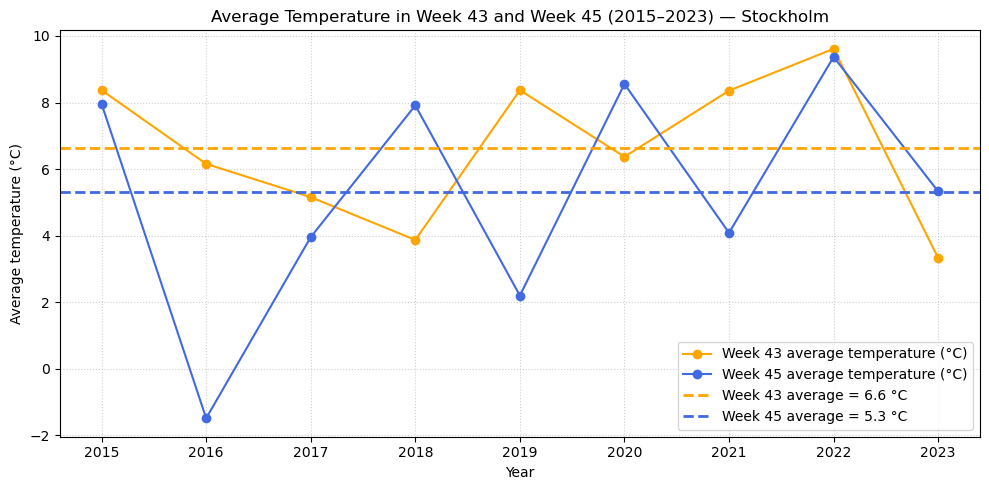

📊 Week 43 average temperature (2015–2023): 6.6 °C
📊 Week 45 average temperature (2015–2023): 5.3 °C

💬 The temperatures in week 43 and week 45 are very similar each year.
This means the change in cycling between week 43 and 45 is likely not due to colder weather.


In [65]:
# Temperature in Week 43 and Week 45 each year (2015–2023)

import matplotlib.pyplot as plt
import pandas as pd

# I select the rows for weeks 43 and 45 between 2015 and 2023
weeks_43_45 = weekly_weather.query("week in [43, 45] and 2015 <= year <= 2023").copy()

# I separate the data into two datasets so I can plot them as different lines
week43 = weeks_43_45[weeks_43_45["week"] == 43].sort_values("year")
week45 = weeks_43_45[weeks_43_45["week"] == 45].sort_values("year")

# I calculate the average temperature for each week
avg43 = week43["temp_mean"].mean()
avg45 = week45["temp_mean"].mean()

# I create the plot
plt.figure(figsize=(10,5))

# I plot the line for week 43 in orange
plt.plot(week43["year"], week43["temp_mean"],
         marker='o', color='orange', label='Week 43 average temperature (°C)')

# I plot the line for week 45 in blue
plt.plot(week45["year"], week45["temp_mean"],
         marker='o', color='royalblue', label='Week 45 average temperature (°C)')

# I add horizontal dashed lines for the averages
plt.axhline(avg43, color='orange', linestyle='--', linewidth=2,
            label=f'Week 43 average = {avg43:.1f} °C')
plt.axhline(avg45, color='royalblue', linestyle='--', linewidth=2,
            label=f'Week 45 average = {avg45:.1f} °C')

# I make the plot clear and easy to read
plt.title("Average Temperature in Week 43 and Week 45 (2015–2023) — Stockholm")
plt.xlabel("Year")
plt.ylabel("Average temperature (°C)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# I print a short summary of what the chart shows
print(f"📊 Week 43 average temperature (2015–2023): {avg43:.1f} °C")
print(f"📊 Week 45 average temperature (2015–2023): {avg45:.1f} °C")
print("\n💬 The temperatures in week 43 and week 45 are very similar each year.")
print("This means the change in cycling between week 43 and 45 is likely not due to colder weather.")


#### Do cycling volumes decrease because of the increase in rainfall?

C:\Users\Lara.Maier\AppData\Local\Temp\ipykernel_24020\2002150823.py:7: RuntimeWarning:

Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.



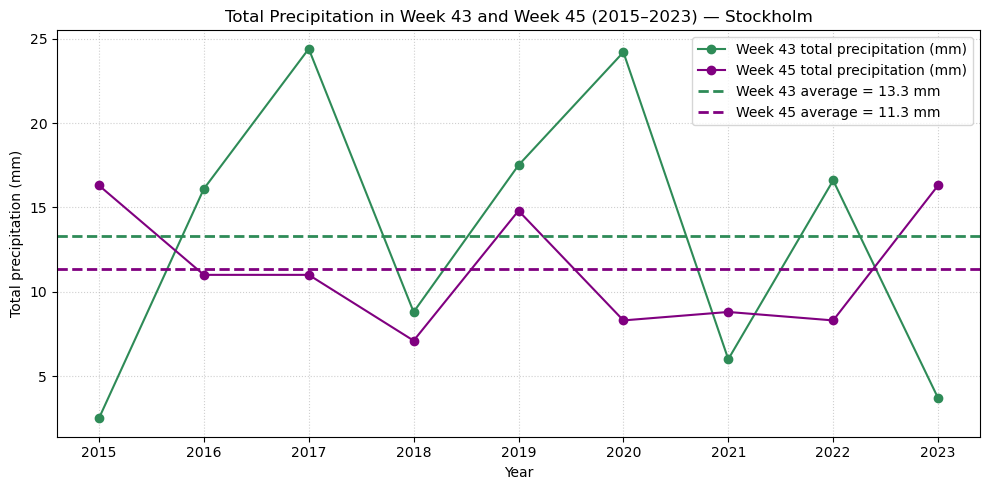

📊 Week 43 average precipitation (2015–2023): 13.3 mm
📊 Week 45 average precipitation (2015–2023): 11.3 mm

💬 The amount of rain in week 43 and week 45 changes somewhat between years,
but there is no clear pattern showing more rain in week 45.
This suggests that the drop in cycling between week 43 and 45 is not caused by weather,
but likely by other factors such as darker days or seasonal changes.


In [66]:
#  Precipitation in Week 43 and Week 45 each year (2015–2023)

import matplotlib.pyplot as plt
import pandas as pd

# I select the rows for weeks 43 and 45 between 2015 and 2023
weeks_43_45 = weekly_weather.query("week in [43, 45] and 2015 <= year <= 2023").copy()

# I separate the data into two datasets so I can plot them as different lines
week43 = weeks_43_45[weeks_43_45["week"] == 43].sort_values("year")
week45 = weeks_43_45[weeks_43_45["week"] == 45].sort_values("year")

# I calculate the average precipitation for each week
avg43 = week43["precip_total"].mean()
avg45 = week45["precip_total"].mean()

# I create the plot
plt.figure(figsize=(10,5))

# I plot the line for week 43 in green
plt.plot(week43["year"], week43["precip_total"],
         marker='o', color='seagreen', label='Week 43 total precipitation (mm)')

# I plot the line for week 45 in purple
plt.plot(week45["year"], week45["precip_total"],
         marker='o', color='purple', label='Week 45 total precipitation (mm)')

# I add horizontal dashed lines for the averages
plt.axhline(avg43, color='seagreen', linestyle='--', linewidth=2,
            label=f'Week 43 average = {avg43:.1f} mm')
plt.axhline(avg45, color='purple', linestyle='--', linewidth=2,
            label=f'Week 45 average = {avg45:.1f} mm')

# I make the plot clear and easy to read
plt.title("Total Precipitation in Week 43 and Week 45 (2015–2023) — Stockholm")
plt.xlabel("Year")
plt.ylabel("Total precipitation (mm)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# I print a short summary of what the chart shows
print(f"📊 Week 43 average precipitation (2015–2023): {avg43:.1f} mm")
print(f"📊 Week 45 average precipitation (2015–2023): {avg45:.1f} mm")
print("\n💬 The amount of rain in week 43 and week 45 changes somewhat between years,")
print("but there is no clear pattern showing more rain in week 45.")
print("This suggests that the drop in cycling between week 43 and 45 is not caused by weather,")
print("but likely by other factors such as darker days or seasonal changes.")


### Hypothesis 5 — Traffic environment

#### Do cyclists avoid routes with many cars because headlights are more annoying in the dark?

### Hypothesis 6 — Outlier paths

#### Which bike paths behaving very differently from the norm?

### Summary

text 
text text

## Primary Conclusion
text
text
text

# Presentation ("Flipping the Pyramid")

## Executive Summary
text
text text

## 1. Key finding

## 2. Key finding

## 3. Key finding

## 4. Key finding